In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import folium
from folium import Choropleth
from folium import GeoJson
import geopandas as gpd

import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('../bin/data_def.csv')

df.head()

provincia                                         link_coche  \
0    Madrid  https://www.autocasion.com/coches-segunda-mano...   
1    Madrid  https://www.autocasion.com/coches-segunda-mano...   
2    Murcia  https://www.autocasion.com/coches-segunda-mano...   
3    Murcia  https://www.autocasion.com/coches-km0/km-0/sko...   
4    Murcia  https://www.autocasion.com/coches-segunda-mano...   

  fecha_extraccion                      marca_modelo   fecha_matriculacion  \
0       25/11/2024  Detalles VOLKSWAGEN Polo (2019)   Matriculado: 10/2019   
1       25/11/2024       Detalles OPEL Corsa (2009)   Matriculado: 07/2009   
2       25/11/2024    Detalles SKODA Octavia (2017)   Matriculado: 08/2017   
3       25/11/2024      Detalles SKODA Kamiq (2024)   Matriculado: 03/2024   
4       25/11/2024    Detalles SKODA Octavia (2024)   Matriculado: 02/2024   

   kilometraje  nombre_vendedor tipo_vendedor distintivo_ambiental  garantia  \
0        93000       COCHES AMB   Profesional                    C  12 meses   
1       236945   AUTOS CAPRICAR   Profesional                    B        No   
2        44300  SKOMOVIL MURCIA   Profesional                  ECO  12 meses   
3        10600  SKOMOVIL MURCIA   Profesional                    C  12 meses   
4        13673  SKOMOVIL MURCIA   Profesional          0 EMISIONES  12 meses   

  precio_contado   precio_nuevo          largo          ancho          alto  \
0          20950          29044  4053 mm Largo  1751 mm Ancho  1461 mm Alto   
1           4000          15660  3999 mm Largo  1737 mm Ancho  1488 mm Alto   
2          15900          25030  4670 mm Largo  1814 mm Ancho  1458 mm Alto   
3          24900  no disponible            NaN            NaN           NaN   
4          33500  no disponible            NaN            NaN           NaN   

                    capacidad_maletero         carroceria         num_plazas  \
0  Capacidad del maletero (l)355/1.125  CarroceríaBerlina  Número de plazas5   
1  Capacidad del maletero (l)285/1.100  CarroceríaBerlina  Número de plazas5   
2  Capacidad del maletero (l)460/1.450  CarroceríaBerlina  Número de plazas5   
3                                  NaN  4x4, SUV o pickup                NaN   
4                                  NaN           Familiar                NaN   

                 batalla                                 peso  \
0  Batalla (mm)\r\n2.548  Peso/Masa max. autorizado (kg)1.855   
1  Batalla (mm)\r\n2.511  Peso/Masa max. autorizado (kg)1.695   
2  Batalla (mm)\r\n2.680  Peso/Masa max. autorizado (kg)1.878   
3                    NaN                                  NaN   
4                    NaN                                  NaN   

          num_puertas                     consumo_medio  \
0  Número de puertas5  Consumo medio 5,80 litros/100 km   
1  Número de puertas5  Consumo medio 4,60 litros/100 km   
2  Número de puertas5  Consumo medio 5,70 litros/100 km   
3           5 Puertas                               NaN   
4           5 Puertas                               NaN   

                         consumo_carretera                     consumo_urbano  \
0  Consumo en carretera 4,90 litros/100 km  Consumo urbano 7,70 litros/100 km   
1  Consumo en carretera 3,80 litros/100 km  Consumo urbano 5,90 litros/100 km   
2  Consumo en carretera 4,60 litros/100 km  Consumo urbano 7,40 litros/100 km   
3                                      NaN                                NaN   
4                                      NaN                                NaN   

                   CO2                                  deposito  \
0  CO2 (g/km) 138 g/km  Depósito de combustible (l) 40,00 litros   
1  CO2 (g/km) 127 g/km  Depósito de combustible (l) 45,00 litros   
2  CO2 (g/km) 101 g/km  Depósito de combustible (l) 50,00 litros   
3                  NaN                                       NaN   
4                  NaN                                       NaN   

                combustible                    cilindros 

## Limpieza preliminar

In [4]:
stats = []
for col in df.columns:
    stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

Columna  Valores únicos    % nulos  \
24                   CO2             216  19.030232   
37           aceleracion             138  17.555134   
36         velocidad_max             140  17.540529   
35                   par             212  17.540529   
15    capacidad_maletero             875  17.540529   
18               batalla             325  17.540529   
33           potencia_kw             226  17.379874   
14                  alto             413  17.365269   
13                 ancho             287  17.365269   
12                 largo             671  17.365269   
25              deposito              86  17.365269   
27             cilindros              10  17.365269   
29     sobrealimentacion               7  17.365269   
31              traccion               6  17.365269   
23        consumo_urbano             196  14.926245   
22     consumo_carretera             122  14.911640   
17            num_plazas              10  14.590332   
32           num_marchas              18  14.269023   
19                  peso             672  13.626406   
21         consumo_medio             175  10.530159   
28            cilindrada             273   6.776691   
34           potencia_cv             391   0.803272   
16            carroceria              16   0.657222   
20           num_puertas               8   0.657222   
26           combustible              15   0.481963   
30           tipo_cambio              10   0.481963   
6        nombre_vendedor             591   0.000000   
2       fecha_extraccion               2   0.000000   
3           marca_modelo            1924   0.000000   
4    fecha_matriculacion             261   0.000000   
5            kilometraje            4574   0.000000   
1             link_coche            6847   0.000000   
7          tipo_vendedor              18   0.000000   
8   distintivo_ambiental               5   0.000000   
9               garantia              64   0.000000   
10        precio_contado            1900   0.000000   
11          precio_nuevo            2736   0.000000   
0              provincia              47   0.000000   

    % of values in the biggest category    tipo  
24                            36.921279  object  
37                            17.555134  object  
36                            17.540529  object  
35                            17.540529  object  
15                            17.540529  object  
18                            17.540529  object  
33                            17.379874  object  
14                            17.365269  object  
13                            17.365269  object  
12                            17.365269  object  
25                            17.365269  object  
27                            46.677377  object  
29                            42.777859  object  
31                            63.093326  object  
23                            39.272674  object  
22                            39.287279  object  
17                            74.485176  object  
32                            32.408354  object  
19                            13.626406  object  
21                            37.578502  object  
28                            11.391850  object  
34                            12.370381  object  
16                            39.301884  object  
20                            72.162991  object  
26                            39.842267  object  
30                            36.833650  object  
6                              5.155543  object  
2                             63.473054  object  
3                              0.832481  object  
4                              2.789543  object  
5                              3.081642   int64  
1                              0.014605  object  
7                             99.459617  object  
8                             57.295166  object  
9                             60.698116  object  
10                             0.744852  object  
11                   

In [5]:
df['tipo_cambio'].unique()

#Hay nans que se toman como floats. Lo convierto a "no disponible"
df['tipo_cambio'] = df['tipo_cambio'].fillna("no disponible")

#No sé qué es manual automatizada, si queremos que sea manual hay que poner la lambda al revés
df['tipo_cambio'] = df['tipo_cambio'].apply(lambda x: 'Manual' if 'Manual' in x else 'Automático')

In [6]:
df["carroceria"] = df["carroceria"].str.replace("Carrocería","")

df["combustible"] = df["combustible"].str.replace("combustible ","").str.replace("Combustible ","")

In [7]:
df['fecha_matriculacion'] = df['fecha_matriculacion'].str.split("Matriculado: ").str[1]

def limpiar_fecha(fecha):
    try:
        mes, ano = fecha.split('/')
        return int(mes), int(ano)
    except:
        return np.nan, int(fecha)

df[['mes_matriculacion', 'ano_matriculacion']] = df['fecha_matriculacion'].apply(lambda x: pd.Series(limpiar_fecha(x)))

df = df.drop(columns=['fecha_matriculacion'])

In [8]:
df['mes_matriculacion'] = df['mes_matriculacion'].fillna(0).astype('int64')
df['ano_matriculacion'] = df['ano_matriculacion'].fillna(0).astype('int64')

In [9]:
df = df[df["tipo_vendedor"] == "Profesional"]
df = df.drop(columns=['tipo_vendedor'])

In [10]:
df["garantia"] = df["garantia"].str.split(' ').str[0].replace("Sí",np.nan).replace("No",0).astype(float)

In [11]:
df["precio_contado"] = pd.to_numeric(df["precio_contado"], errors='coerce')

df["precio_nuevo"] = pd.to_numeric(df["precio_nuevo"], errors='coerce')

df['largo'] = pd.to_numeric(df['largo'].str.extract('(\d+\.?\d*)')[0], errors='coerce')
df['ancho'] = pd.to_numeric(df['ancho'].str.extract('(\d+\.?\d*)')[0], errors='coerce')
df['alto'] = pd.to_numeric(df['alto'].str.extract('(\d+\.?\d*)')[0], errors='coerce')

df['capacidad_maletero'] = pd.to_numeric(df['capacidad_maletero'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
df["num_plazas"] = df["num_plazas"].str.split("s").str[1].astype("Int64")
df["batalla"] = (df["batalla"].str.replace(r'Batalla \(mm\)\s*', '', regex=True).str.replace('.', '', regex=False))
df["batalla"] = pd.to_numeric(df["batalla"], errors='coerce').astype("Int64")
df["peso"] = df["peso"].str.replace('Peso/Masa max. autorizado (kg)', '').str.replace('.','').astype("Int64")
df["num_puertas"] = df["num_puertas"].str.extract(r'(\d+)').astype("Int64")
df["consumo_medio"] = df["consumo_medio"].str.extract(r'(\d+,\d+)').replace(',', '.', regex=True).astype(float)
df["consumo_carretera"] = df["consumo_carretera"].str.extract(r'(\d+,\d+)').replace(',', '.', regex=True).astype(float)
df["consumo_urbano"] = df["consumo_urbano"].str.extract(r'(\d+,\d+)').replace(',', '.', regex=True).astype(float)
df["co2"] = df["CO2"].str.extract(r'(\d{1,3})(?= g/km)')[0].astype(float)
df["num_cilindros"] = df["cilindros"].str.extract(r'(\d+)').astype("Int64")
df["cilindrada"] = df["cilindrada"].str.extract(r'(\d+,\d+|\d+\.\d+)', expand=False).str.replace(',', '').str.replace('.', '').astype("Int64")
df["deposito"] = df["deposito"].str.extract(r'(\d+,\d+)').replace(',', '.', regex=True).astype(float)

df["num_marchas"] = df["num_marchas"].str.extract(r'(\d+)').astype("Int64")
df["potencia_kw"] = df["potencia_kw"].str.extract(r'(\d+)').astype("Int64")
df["potencia_cv"] = df["potencia_cv"].str.extract(r'(\d+)').astype("Int64")
df["par"] = df["par"].str.extract(r'(\d+)').astype("Int64")
df["velocidad_max"] = df["velocidad_max"].str.extract(r'(\d+)').astype("Int64")
df["aceleracion"] = df["aceleracion"].str.extract(r'(\d+,\d+|\d+\.\d+)')[0].str.replace(",", ".").astype(float)
df['id_sobrealimentacion'] = df['sobrealimentacion'].apply(lambda x: x.replace('Sobrealimentación', '').replace('Tipo de sobrealimentador', 'no disponible').strip() if pd.notna(x) and x != '-' else 'no disponible')

In [12]:
df["traccion"].unique()

df["traccion"] = df['traccion'].fillna("no disponible")
df["traccion"] = df["traccion"].str.replace('Tracción', '').str.replace('Todo terreno tracción', '').apply(lambda x: x.strip())

In [13]:
marca_listado = pd.read_csv('../bin/listado_marcas.csv')

lista_marcas = [marca.upper() for marca in marca_listado['nombre_marca'].tolist()]

df['marca_modelo'] = df['marca_modelo'].fillna('').str.replace("Detalles ", "").str.strip().str.upper()

df['marca'] = df['marca_modelo'].apply(lambda x: next((marca for marca in lista_marcas if marca in x), np.nan))
df['modelo'] = df.apply(lambda x: re.sub(r'\s*\(.*?\)', '', x['marca_modelo'].replace(x['marca'], "").strip()).strip() if pd.notnull(x['marca']) else x['marca_modelo'], axis=1)

In [14]:
df = df.drop(columns=['marca_modelo', 'CO2', 'cilindros', 'sobrealimentacion', 'carroceria'])

In [15]:
df.rename(columns={'distintivo_ambiental': 'id_distintivo_ambiental'
                  , 'marca': 'id_marca'
                  , 'modelo': 'id_modelo'
                  , 'nombre_vendedor': 'id_concesionario'
                  , 'provincia': 'id_provincia'
                  , 'traccion': 'id_traccion'}, inplace=True)

In [16]:
df['combustible'] = (
    df['combustible']
    .str.replace('-', 'no disponible')
    .str.replace('Diésel', 'Diesel')
    .str.replace('Gasolina y corriente eléctrica', 'Híbrido Enchufable', regex=False)
    .str.replace('Diesel y corriente eléctrica', 'Híbrido Enchufable', regex=False)
    .str.replace('Corriente eléctrica', 'Eléctrico', regex=False)
    .str.replace(r'\bHíbrido\b(?!.*Enchufable)', 'Híbrido Enchufable', regex=True)
)

In [17]:
df['id_concesionario'] = df['id_concesionario'].apply(lambda x: x.split('-')[0])
df['id_concesionario'] = df['id_concesionario'].apply(lambda x: x.split(',')[0])

In [18]:
for columna in df.columns:
    df[columna] = df[columna].replace(["no disponible", "<NA>", "-", "0", 0, np.nan], None)
    

In [19]:
df = df[df['precio_contado'].notna()]

## Rtdo limpieza

In [21]:
df.sample(10)

id_provincia                                         link_coche  \
5117       Madrid  https://www.autocasion.com/coches-segunda-mano...   
5077       Madrid  https://www.autocasion.com/coches-segunda-mano...   
4533      Córdoba  https://www.autocasion.com/coches-km0/km-0/vol...   
615        Málaga  https://www.autocasion.com/coches-segunda-mano...   
2388       Madrid  https://www.autocasion.com/coches-segunda-mano...   
5238       Madrid  https://www.autocasion.com/coches-segunda-mano...   
6468       Málaga  https://www.autocasion.com/coches-segunda-mano...   
3723      Córdoba  https://www.autocasion.com/coches-segunda-mano...   
5931     Zaragoza  https://www.autocasion.com/coches-km0/km-0/sea...   
1918    La Coruña  https://www.autocasion.com/coches-km0/km-0/for...   

     fecha_extraccion kilometraje                           id_concesionario  \
5117       26/11/2024      142593                       AUTOMOVILES CANALCAR   
5077       26/11/2024      111882                                   JARMAUTO   
4533       26/11/2024          66                          Holamotor Córdoba   
615        25/11/2024       68236                              AUTOS MOLIERE   
2388       25/11/2024       49137                                    YAMOVIL   
5238       26/11/2024       91854                       AUTOMOVILES CANALCAR   
6468       26/11/2024      107831                            FLEXICAR MÁLAGA   
3723       26/11/2024       94000                         AUTOMOVILES MARTIN   
5931       26/11/2024           1  AUTOMÓVILES SÁNCHEZ Concesionario Oficial   
1918       25/11/2024       12292                                   GONZACAR   

     id_distintivo_ambiental garantia precio_contado precio_nuevo   largo  \
5117                       C     12.0        19490.0      53120.0  4365.0   
5077                       C     12.0        25200.0      39839.0  4509.0   
4533                       C     12.0        49490.0      60619.0  4866.0   
615                        C     12.0        19890.0      27990.0  4138.0   
2388             0 EMISIONES     12.0        12450.0      24205.0  3495.0   
5238                       C     12.0        11990.0      30270.0  4830.0   
6468                    None     12.0        15490.0         None    None   
3723                       B     None        27800.0      43300.0  4315.0   
5931                       C     34.0        19300.0      23040.0  4059.0   
1918                     ECO     24.0        34995.0         None    None   

       ancho    alto capacidad_maletero num_plazas batalla  peso num_puertas  \
5117  1965.0  1635.0              575.0          5    2660  2200           5   
5077  1839.0  1675.0              615.0          5    2678  2140           5   
4533  1871.0  1462.0              590.0          5    2840  2170           5   
615   1780.0  1552.0              400.0          5    2566  1760           5   
2388  1665.0  1554.0              185.0          4    2494  1560           5   
5238  1828.0  1456.0              473.0          5    2817  2065           4   
6468    None    None               None       None    None  None           5   
3723  1885.0  1830.0               None          5    2450  2600           3   
5931  1780.0  1447.0              355.0          5    2564  1680           5   
1918    None    None               None       None    None  None           5   

     consumo_medio consumo_carretera consumo_urbano deposito  \
5117           6.5               4.6            8.4     60.0   
5077          None              None           None     58.0   
4533          None              None           None     66.0   
615            4.8               4.4            5.4     40.0   
2388          None              None           None     None   
5238           4.4               3.6            5.9     72.0   
6468           5.5               4.5            7.4     None   
3723           8.4               7.1           10.5     87.0   
5931          None        

In [22]:
stats = []
for col in df.columns:
    stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

Columna  Valores únicos    % nulos  \
33                      co2             207  56.208236   
19           consumo_urbano             142  56.161616   
18        consumo_carretera              82  56.161616   
17            consumo_medio             114  50.458430   
35     id_sobrealimentacion               5  34.079254   
22               cilindrada             199  28.189588   
20                 deposito              81  24.413364   
34            num_cilindros               7  23.512044   
12       capacidad_maletero             359  19.906760   
29            velocidad_max             137  19.704740   
30              aceleracion             136  19.456099   
28                      par             205  19.347319   
11                     alto             398  17.824398   
9                     largo             651  17.762238   
14                  batalla             319  17.700078   
10                    ancho             279  17.606838   
13               num_plazas               5  17.544678   
24              id_traccion               4  17.544678   
26              potencia_kw             220  17.389277   
8              precio_nuevo            2616  17.031857   
25              num_marchas               9  14.529915   
15                     peso             591  13.923854   
6                  garantia              61   9.728050   
5   id_distintivo_ambiental               4   5.034965   
3               kilometraje            4318   1.802642   
27              potencia_cv             259   0.714841   
21              combustible               6   0.699301   
16              num_puertas               4   0.683761   
36                 id_marca              51   0.279720   
0              id_provincia              46   0.015540   
23              tipo_cambio               2   0.000000   
31        mes_matriculacion              12   0.000000   
32        ano_matriculacion              27   0.000000   
1                link_coche            6435   0.000000   
7            precio_contado            1577   0.000000   
4          id_concesionario             534   0.000000   
2          fecha_extraccion               2   0.000000   
37                id_modelo             431   0.000000   

    % of values in the biggest category    tipo  
33                            56.208236  object  
19                            56.161616  object  
18                            56.161616  object  
17                            50.458430  object  
35                            43.045843  object  
22                            28.189588  object  
20                            24.413364  object  
34                            46.511267  object  
12                            19.906760  object  
29                            19.704740  object  
30                            19.456099  object  
28                            19.347319  object  
11                            17.824398  object  
9                             17.762238  object  
14                            17.700078  object  
10                            17.606838  object  
13                            74.654235  object  
24                            63.838384  object  
26                            17.389277  object  
8                             17.031857  object  
25                            33.271173  object  
15                            13.923854  object  
6                             60.404040  object  
5                             57.202797  object  
3                              3.139083  object  
27                            13.923854  object  
21                            45.454545  object  
16                            86.915307  object  
36                            10.567211  object  
0                             35.664336  object  
23                            57.700078  object  
31                            12.680653   int64  
32                            22.191142   int64  
1                              0.015540  object  
7      

In [23]:
df.to_csv('../bin/data_preprocess.csv', index=False)

## Gráficos

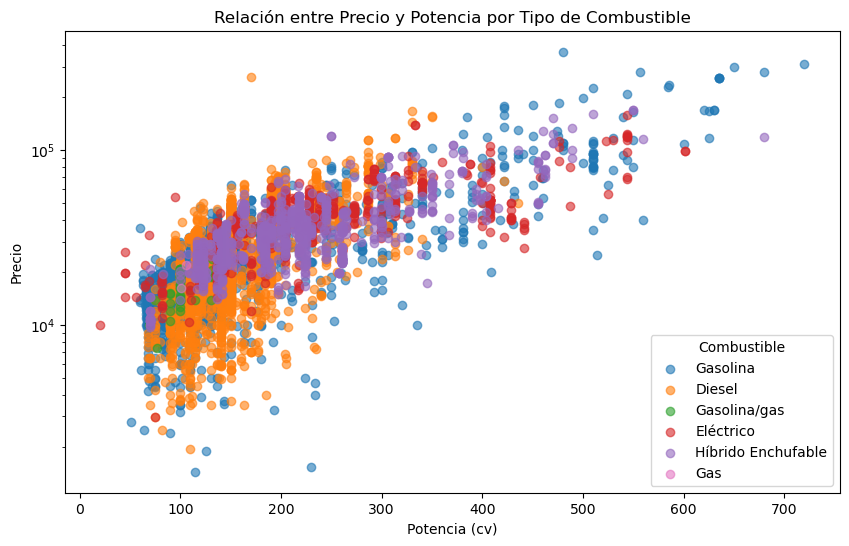

In [25]:
plt.figure(figsize=(10, 6))
for tipo_combustible in df['combustible'].unique():
    subset = df[df['combustible'] == tipo_combustible]
    plt.scatter(subset['potencia_cv'], subset['precio_contado'], label=tipo_combustible, alpha=0.6)

# Configurar etiquetas y título
plt.xlabel('Potencia (cv)')
plt.ylabel('Precio')
plt.title('Relación entre Precio y Potencia por Tipo de Combustible')
plt.legend(title='Combustible')
plt.yscale('log')

#Guardamos la imagen para usarla en Streamlit
plt.savefig('../bin/imagenes/grafico_precio_potencia.png')

plt.show()



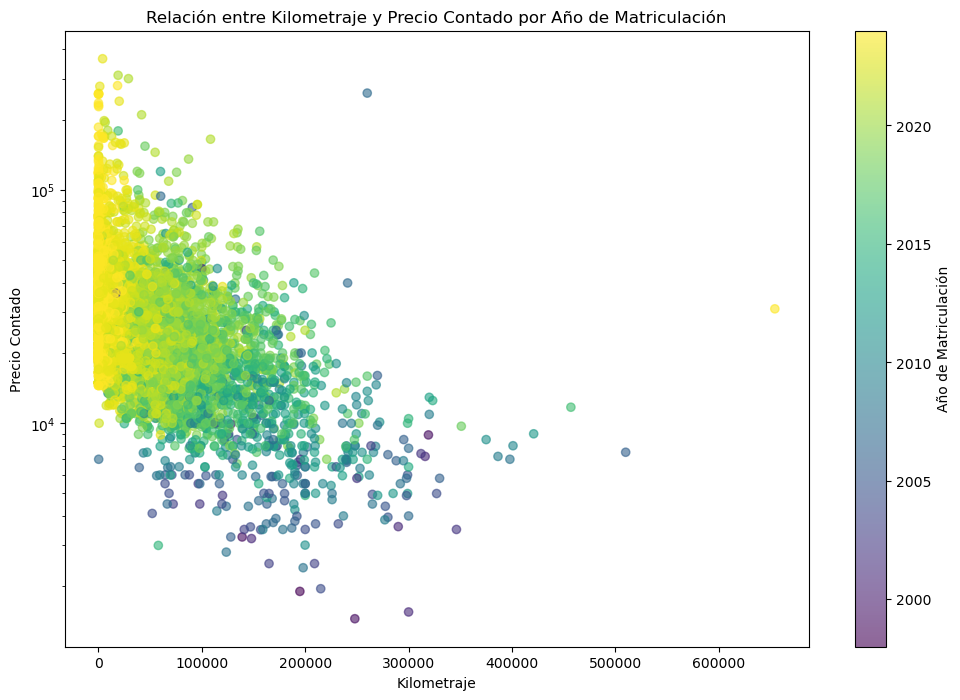

In [26]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['kilometraje'], df['precio_contado'], c=df['ano_matriculacion'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Año de Matriculación')

# Configurar etiquetas y título
plt.xlabel('Kilometraje')
plt.ylabel('Precio Contado')
plt.title('Relación entre Kilometraje y Precio Contado por Año de Matriculación')
plt.yscale('log')

#Guardamos la imagen para usarla en Streamlit
plt.savefig('../bin/imagenes/grafico_kilometraje_precio.png')

plt.show()



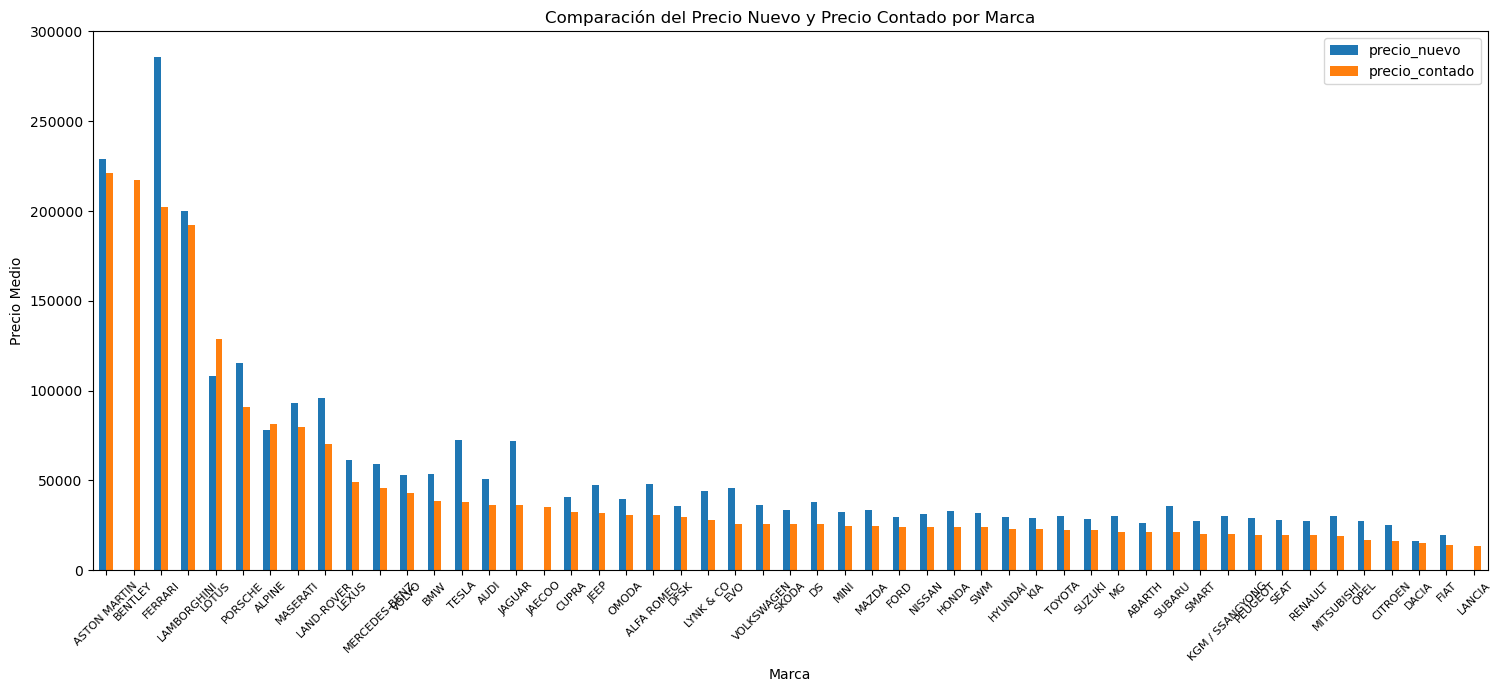

In [27]:
precio_medio = df.groupby('id_marca')[['precio_nuevo', 'precio_contado']].mean().sort_values(by='precio_contado', ascending=False)

precio_medio.plot(kind='bar', figsize=(18, 7))
plt.xlabel('Marca')
plt.ylabel('Precio Medio')
plt.title('Comparación del Precio Nuevo y Precio Contado por Marca')
plt.xticks(rotation=45, fontsize=8)

#Guardamos la imagen para usarla en Streamlit
plt.savefig('../bin/imagenes/grafico_precio_nuevo_contado.png')

plt.show()



<Figure size 2000x1500 with 0 Axes>

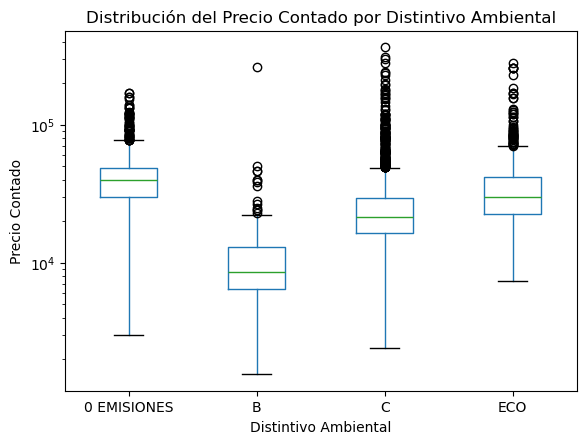

In [28]:
plt.figure(figsize=(20, 15))
df.boxplot(column='precio_contado', by='id_distintivo_ambiental', grid=False)
plt.xlabel('Distintivo Ambiental')
plt.ylabel('Precio Contado')
plt.title('Distribución del Precio Contado por Distintivo Ambiental')
plt.suptitle('')  # Elimina el título automático generado por boxplot
plt.yscale('log')

#Guardamos la imagen para usarla en Streamlit
plt.savefig('../bin/imagenes/grafico_precio_distintivo.png')

plt.show()



## Visualizaciones

In [30]:
df.columns

Index(['id_provincia', 'link_coche', 'fecha_extraccion', 'kilometraje',
       'id_concesionario', 'id_distintivo_ambiental', 'garantia',
       'precio_contado', 'precio_nuevo', 'largo', 'ancho', 'alto',
       'capacidad_maletero', 'num_plazas', 'batalla', 'peso', 'num_puertas',
       'consumo_medio', 'consumo_carretera', 'consumo_urbano', 'deposito',
       'combustible', 'cilindrada', 'tipo_cambio', 'id_traccion',
       'num_marchas', 'potencia_kw', 'potencia_cv', 'par', 'velocidad_max',
       'aceleracion', 'mes_matriculacion', 'ano_matriculacion', 'co2',
       'num_cilindros', 'id_sobrealimentacion', 'id_marca', 'id_modelo'],
      dtype='object')

In [31]:
categorical_columns = ['id_provincia', 'id_concesionario', 'id_distintivo_ambiental','combustible','tipo_cambio', 'id_traccion', 'mes_matriculacion'
               , 'ano_matriculacion','id_sobrealimentacion', 'id_marca', 'id_modelo']
continuous_columns = []

for columna in df.columns: 
    if columna not in categorical_columns: 
        continuous_columns.append(columna)

In [32]:
def metricas (df, columna):
    
    if columna in categorical_columns:
        
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        sns.countplot(data=df, x=columna)
        plt.title(f'Distribución de {columna}')
        plt.xticks(rotation=45, ha='right')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x=columna, y='precio_contado')
        plt.title(f'Boxplot de {columna} con precio')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right')
        plt.show()
    
    elif columna in continuous_columns:

        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 3, 1)
        sns.histplot(df[columna], kde=True)
        plt.title(f'Histograma de {columna}')
        
        
        plt.subplot(1, 3, 2)
        sns.boxplot(x=df[columna])
        plt.title(f'Boxplot de {columna}')
        plt.xticks(rotation=45, ha='right')
        
        plt.subplot(1, 3, 3)
        sns.scatterplot(x=df[columna], y=df['precio_contado'])
        plt.title(f'Scatterplot de {columna} con precio')
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right')
        plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_25300\888676564.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


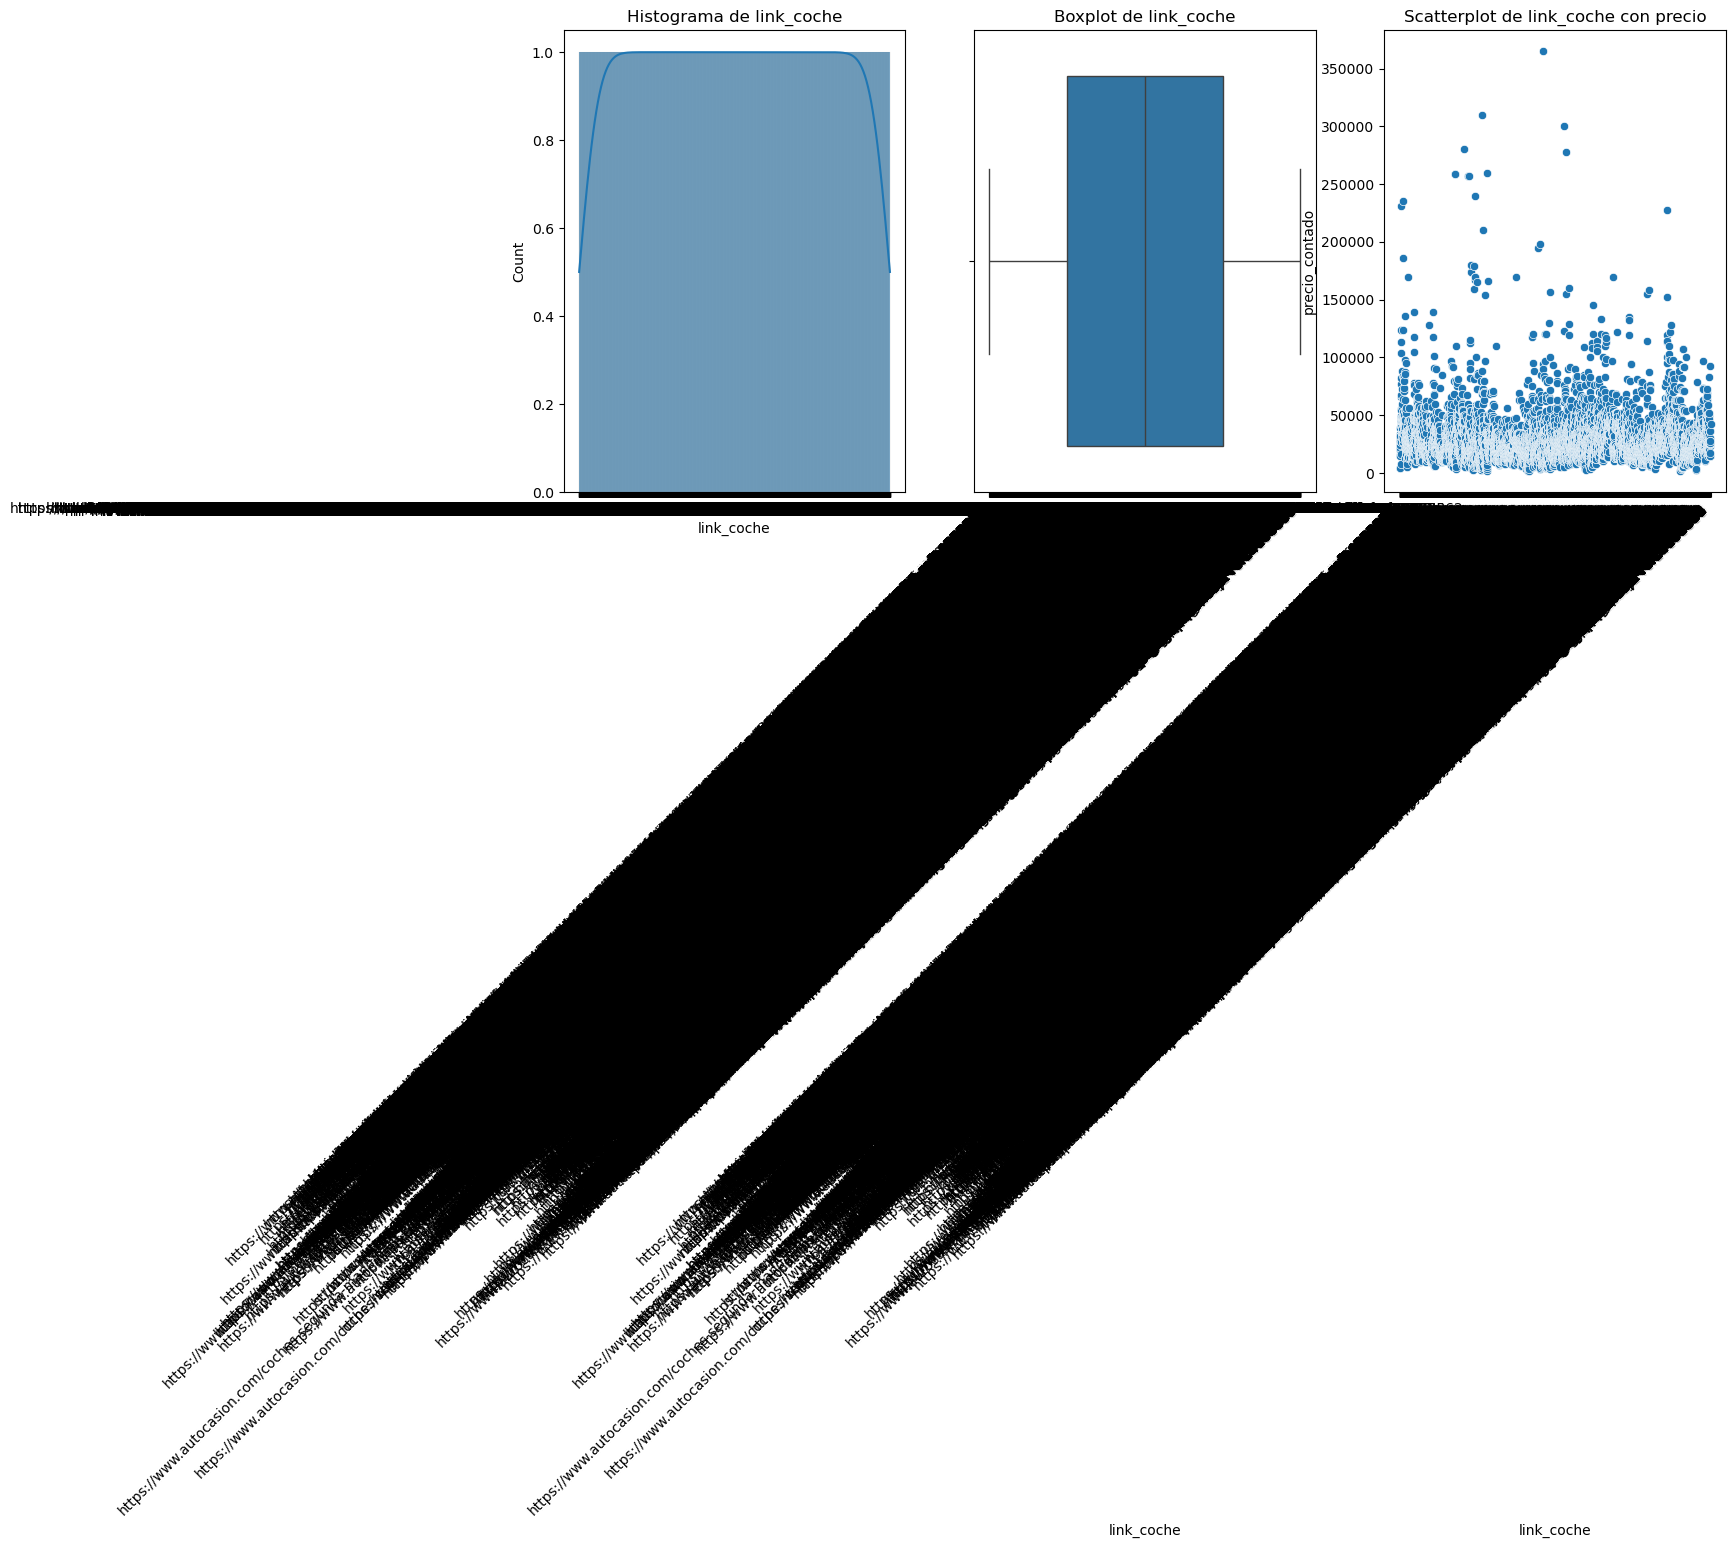

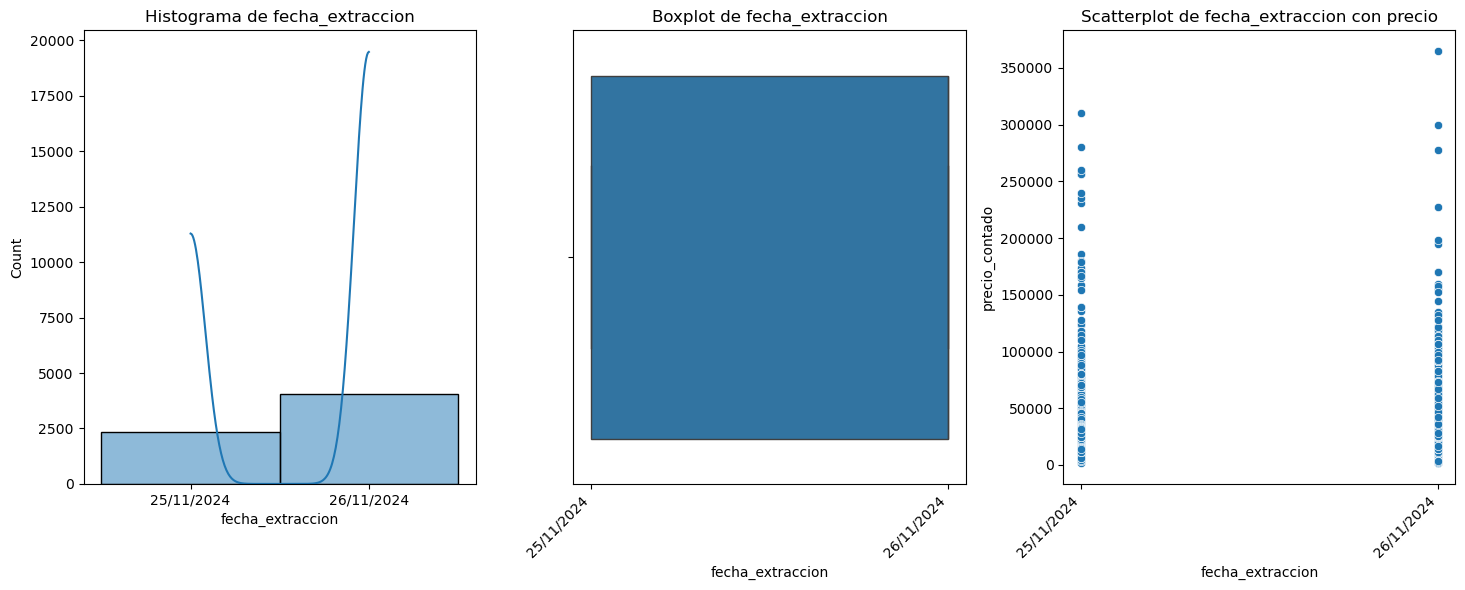

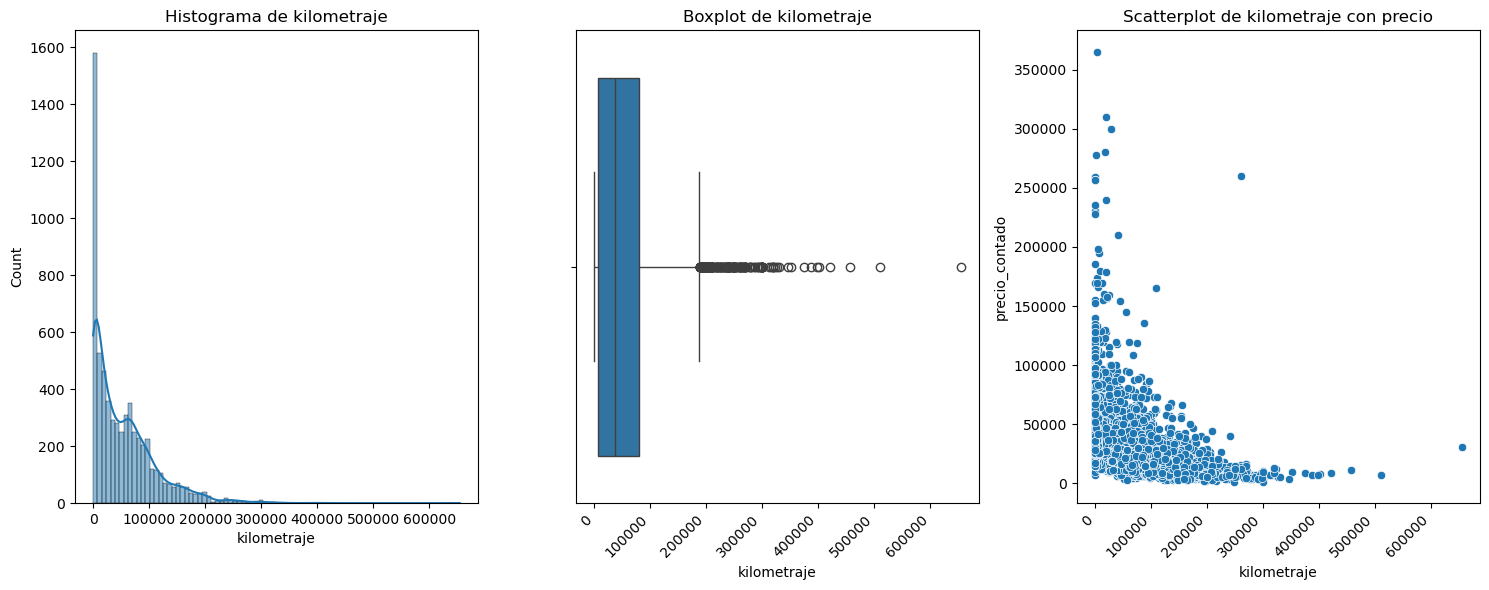

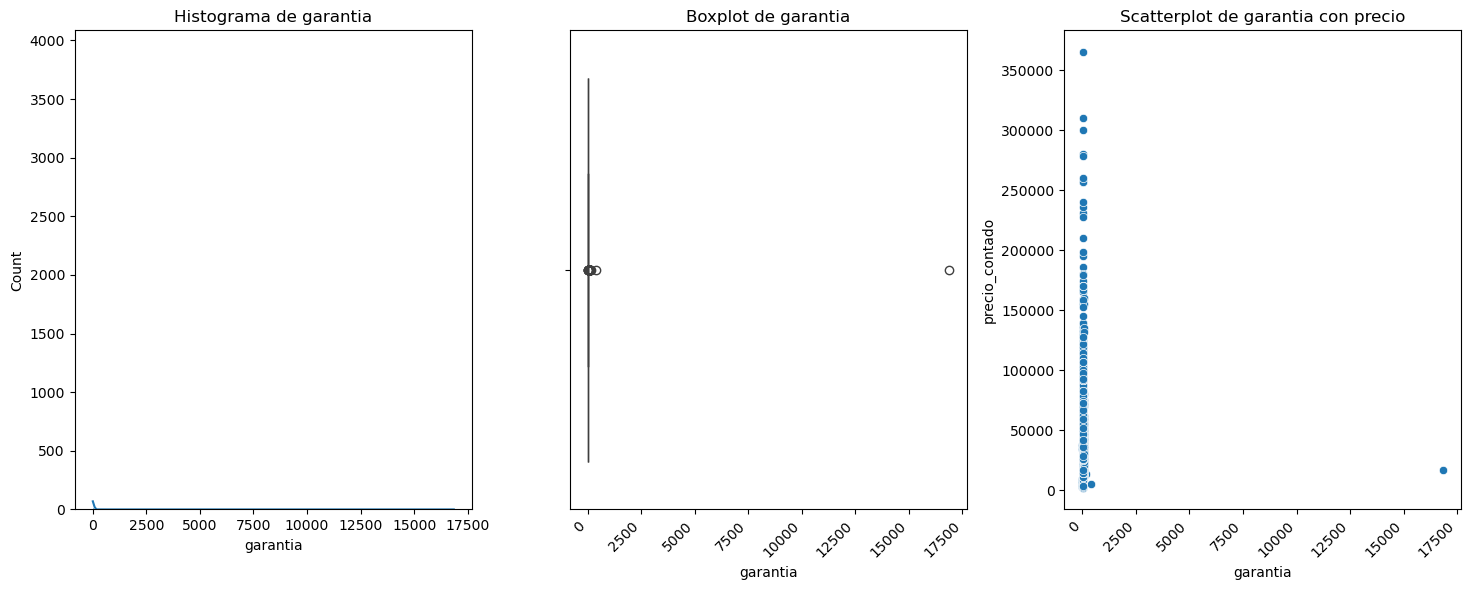

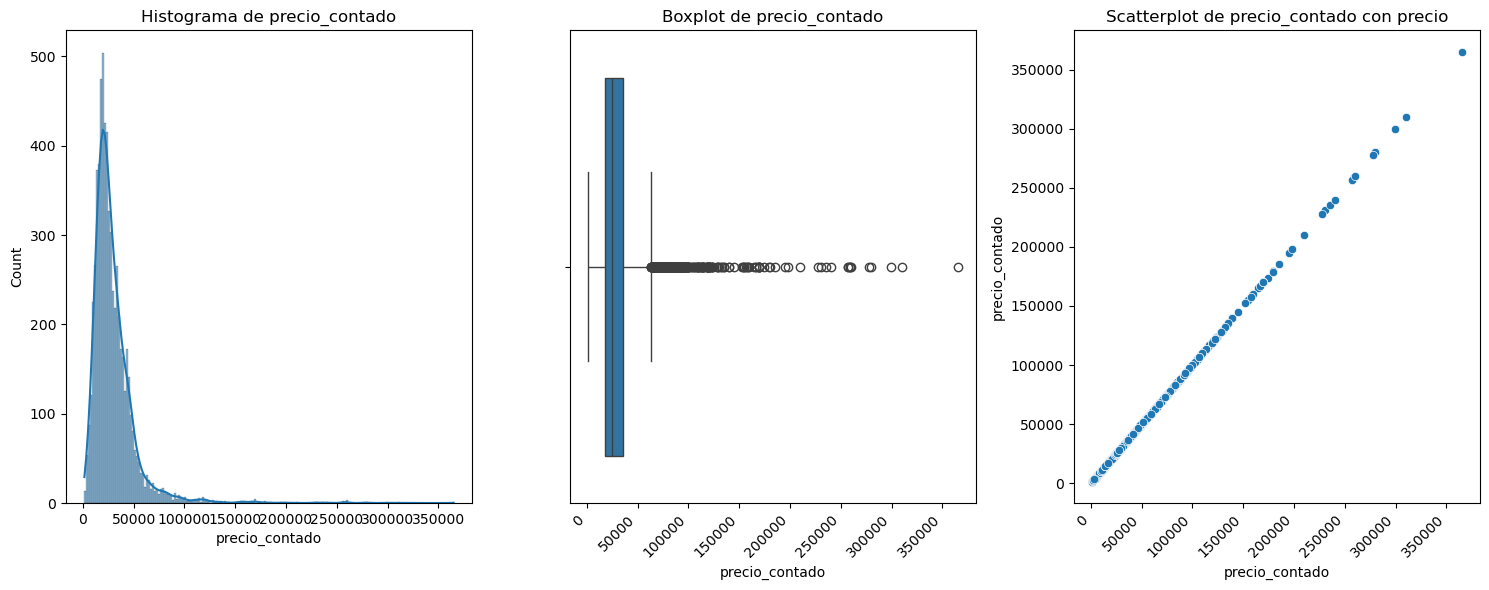

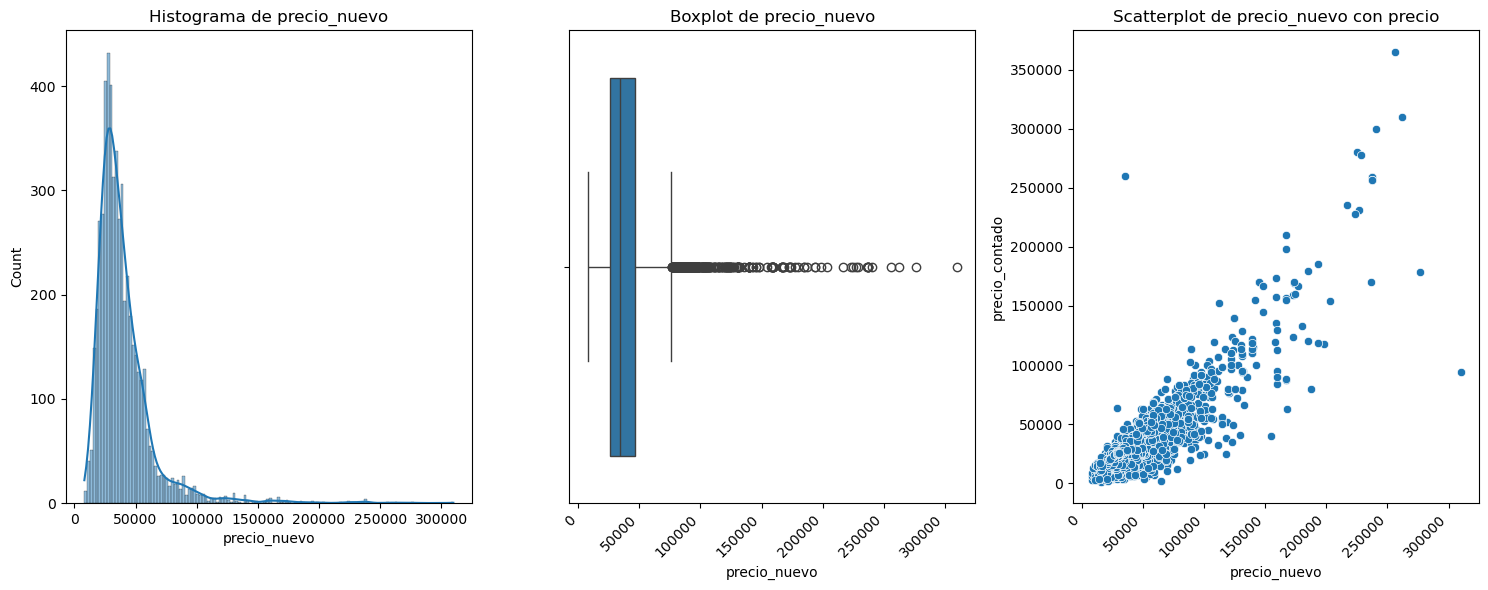

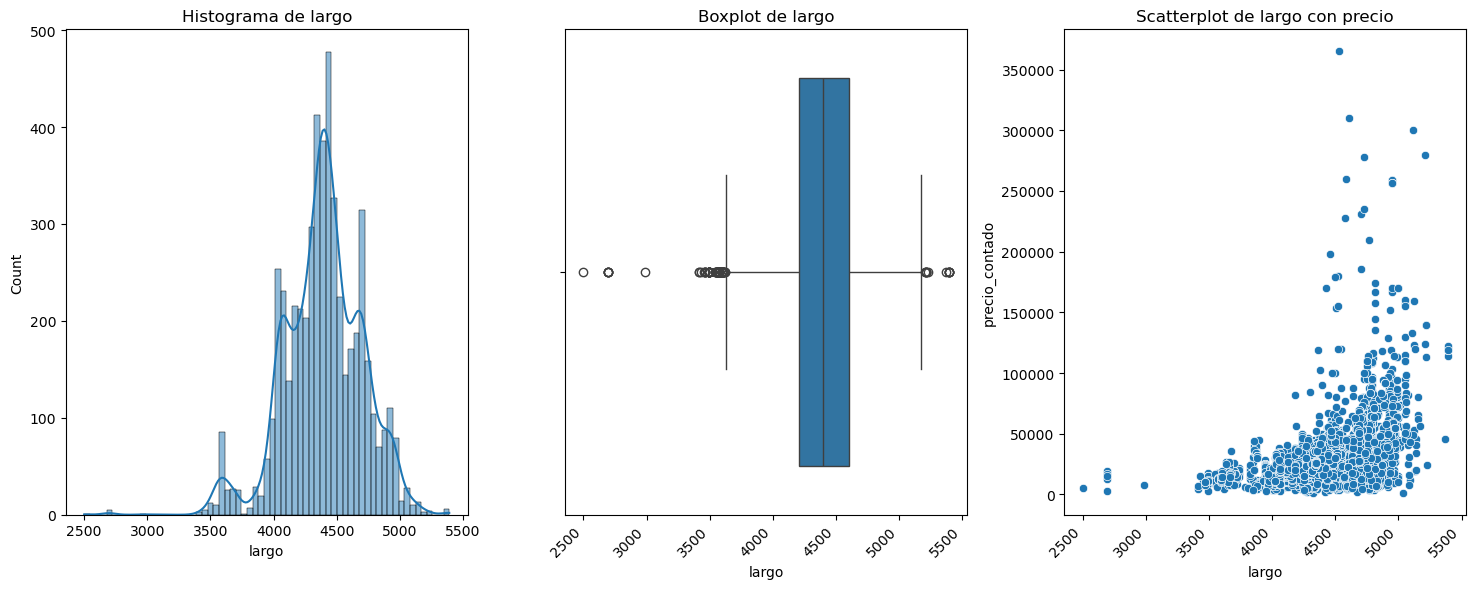

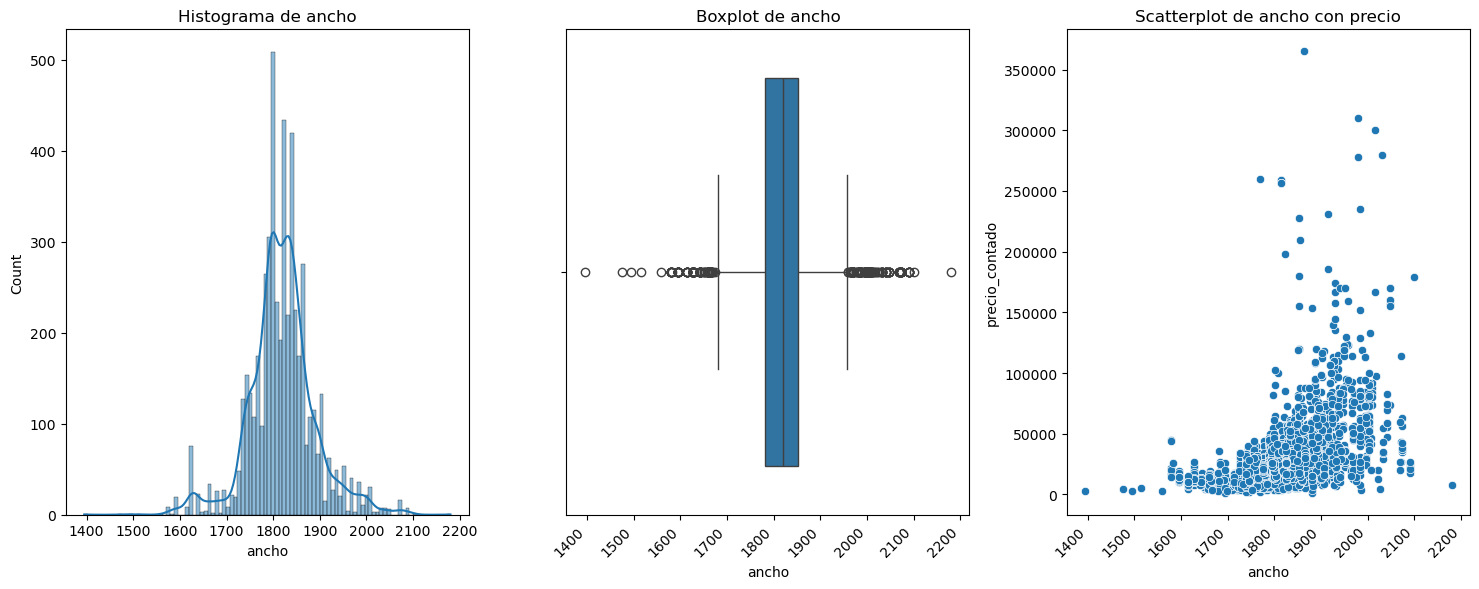

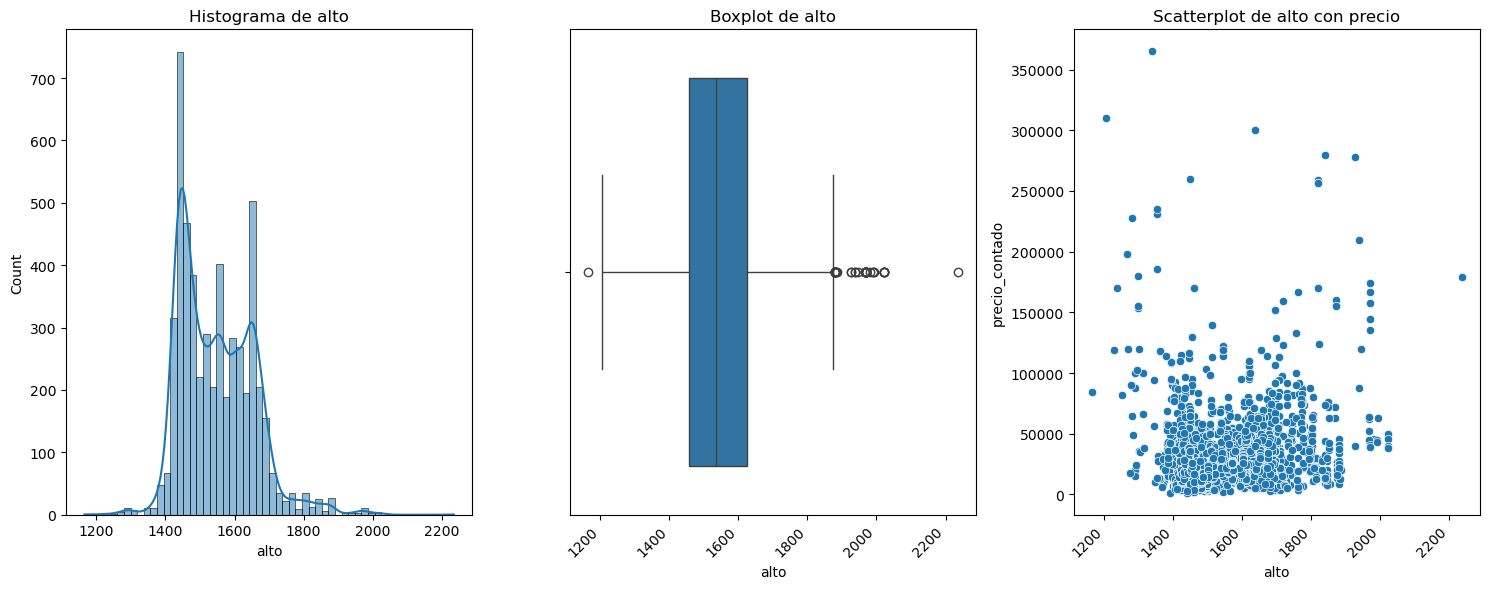

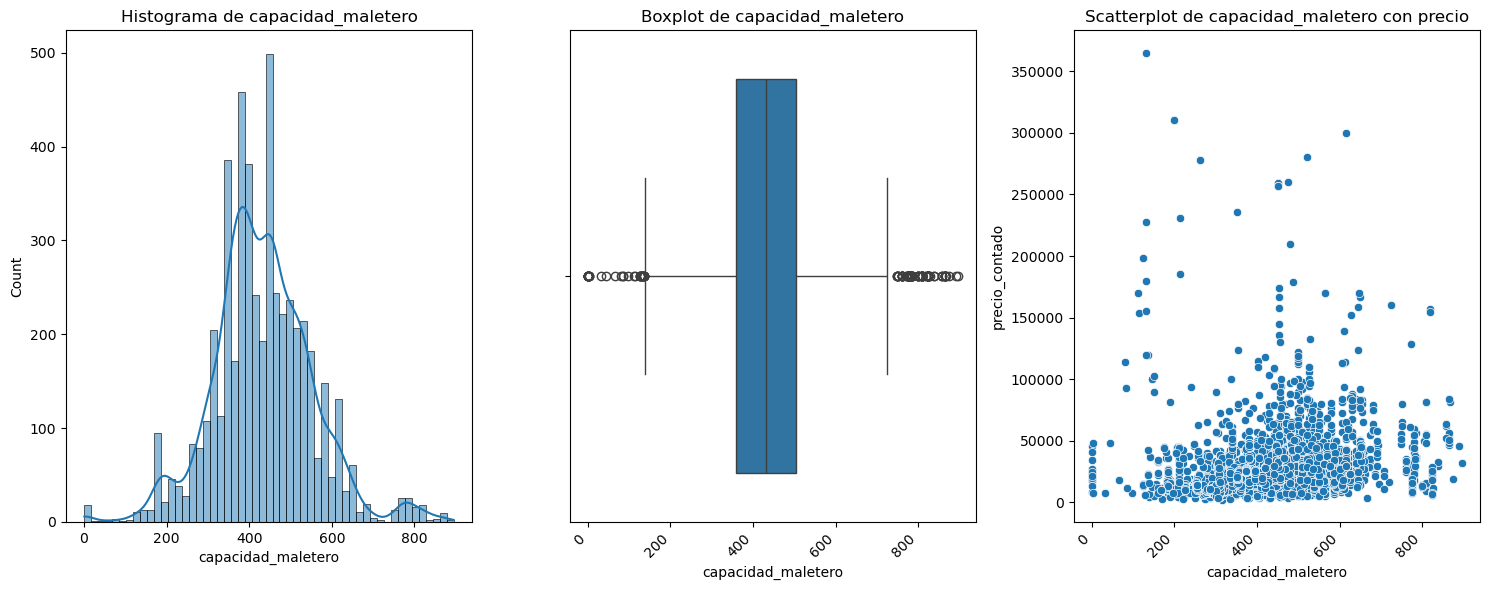

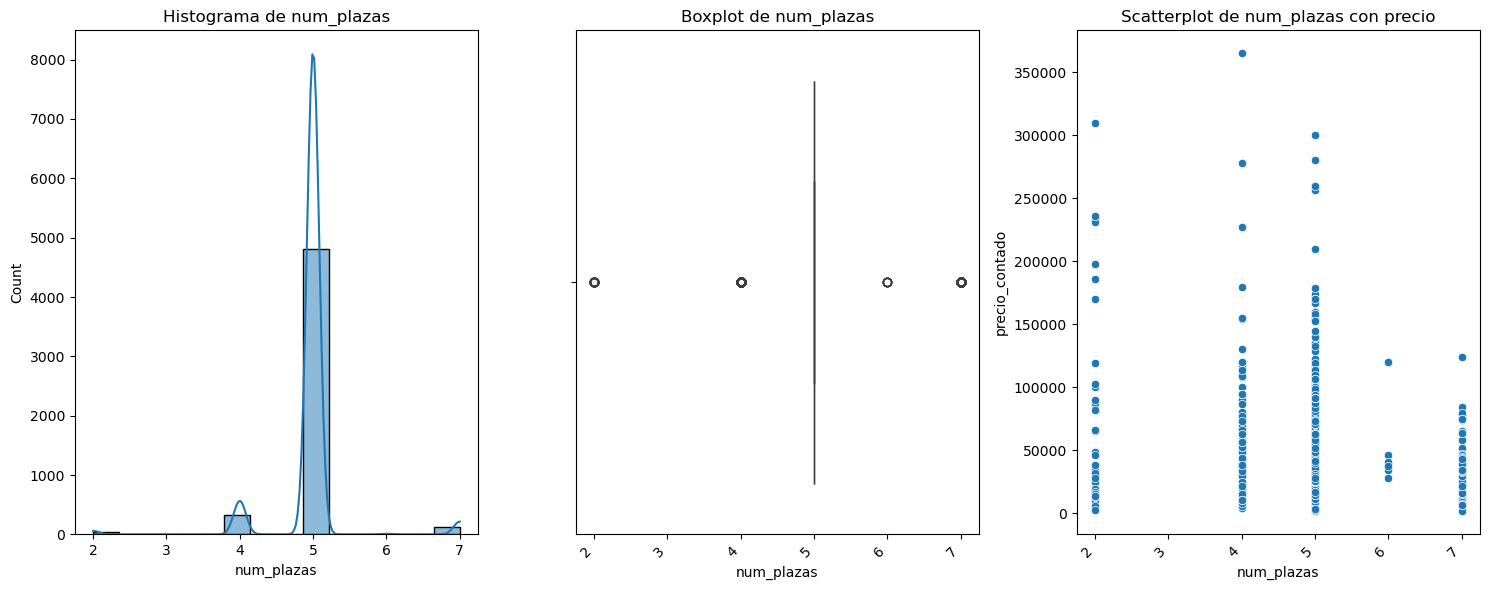

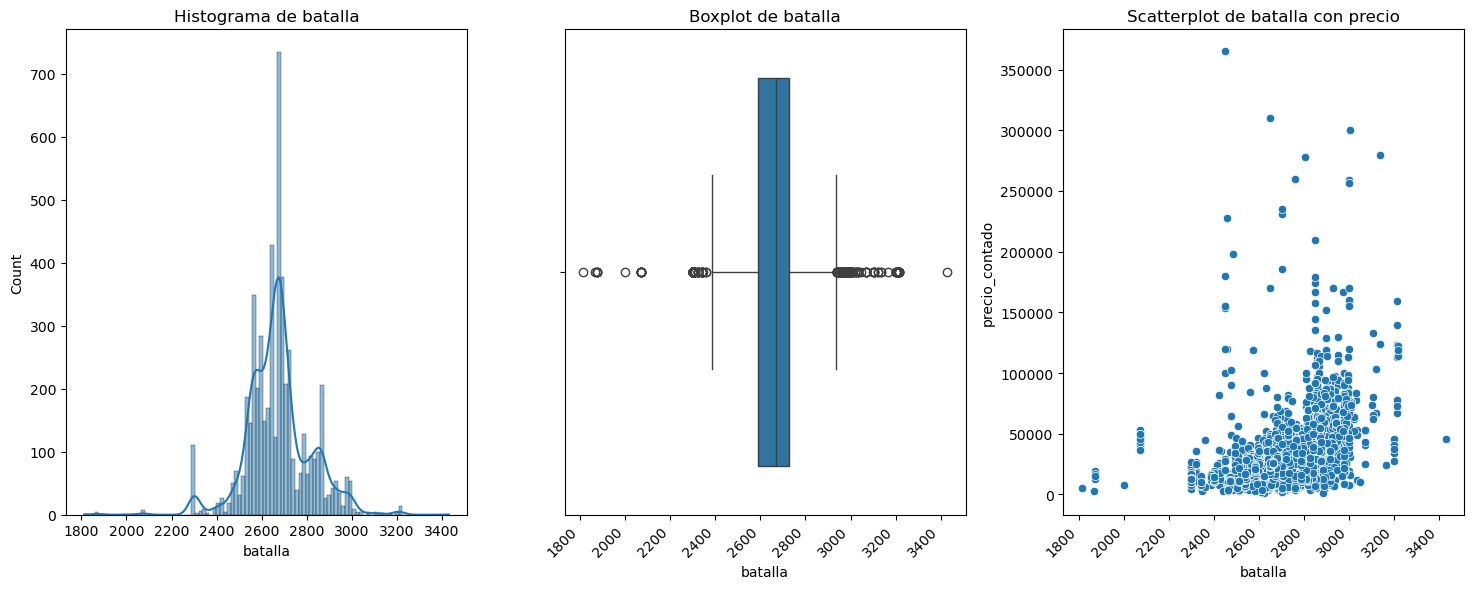

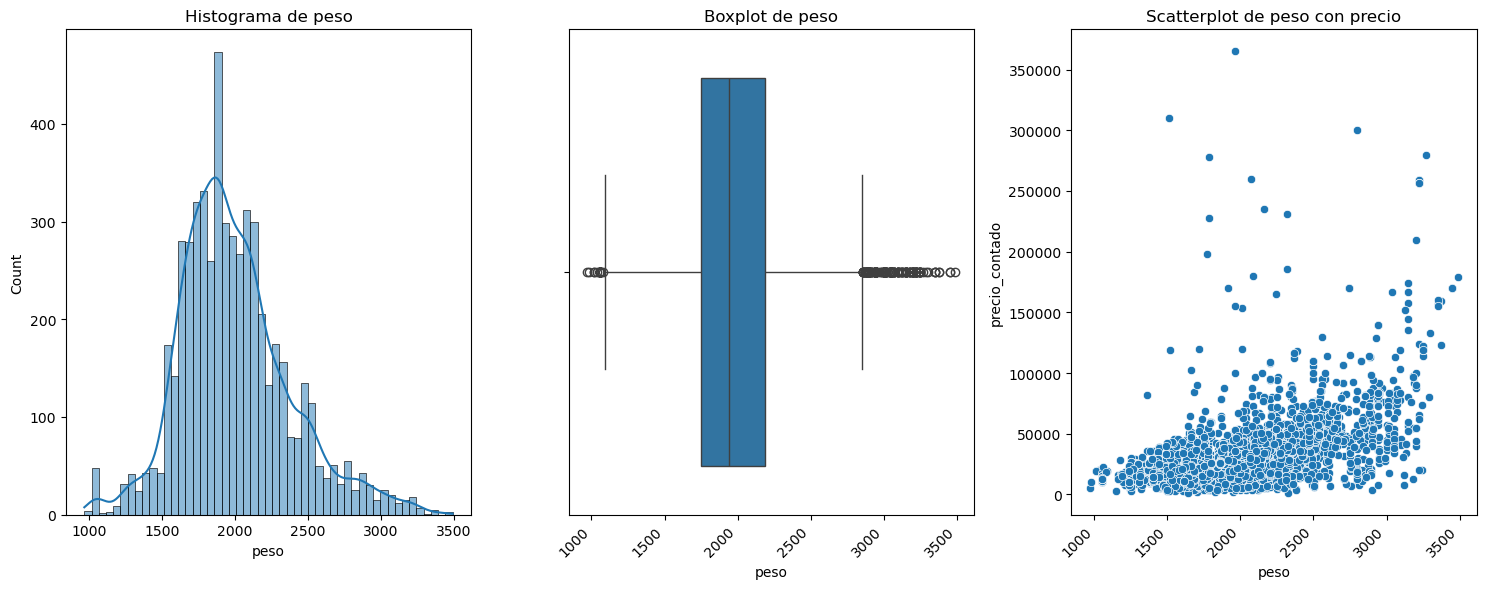

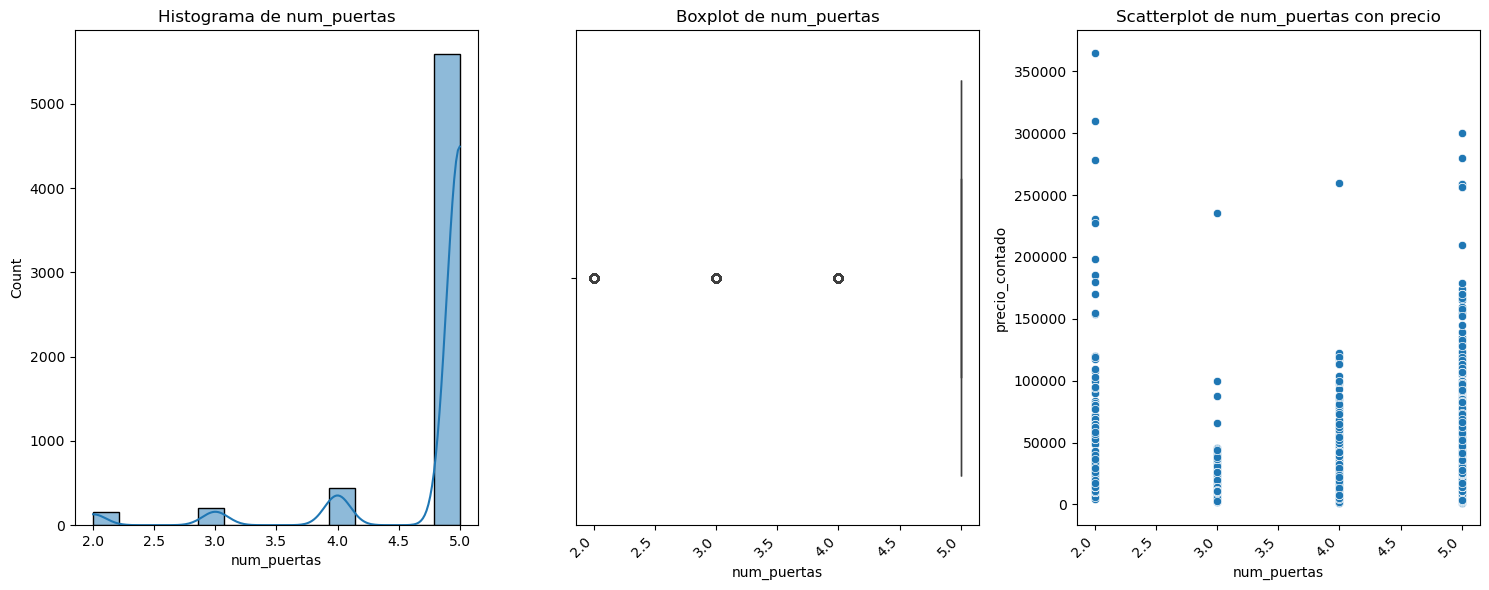

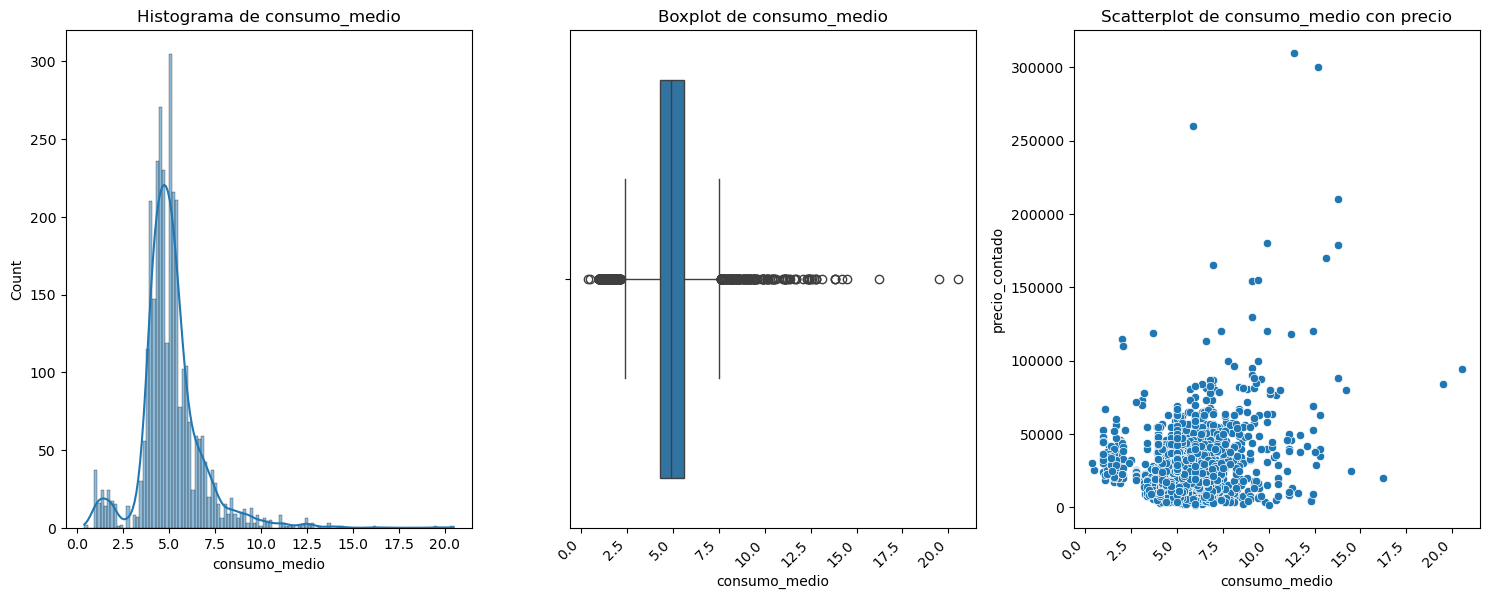

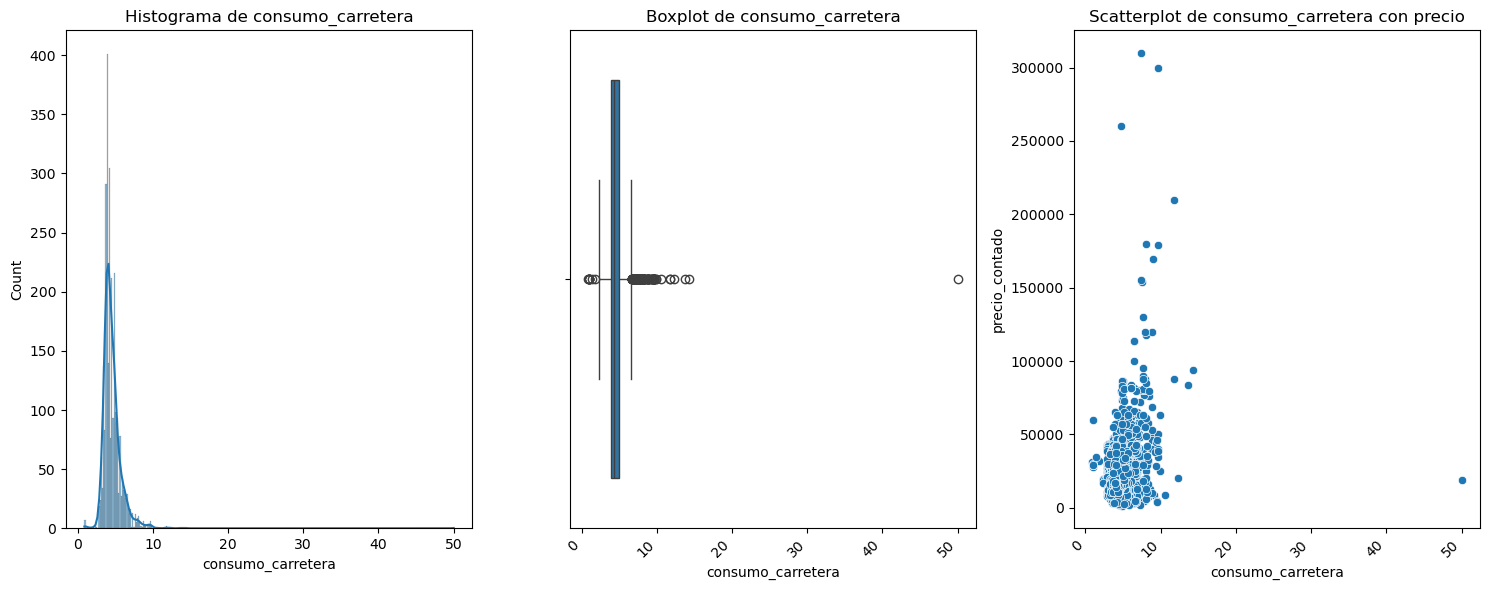

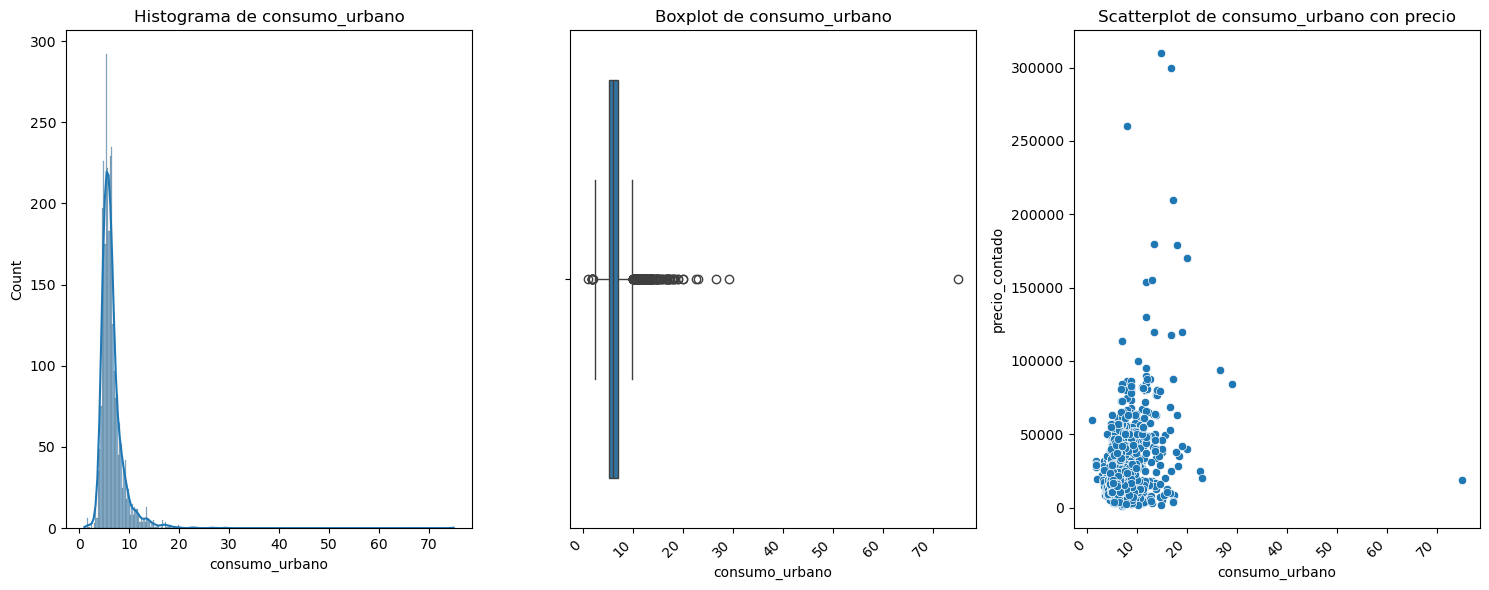

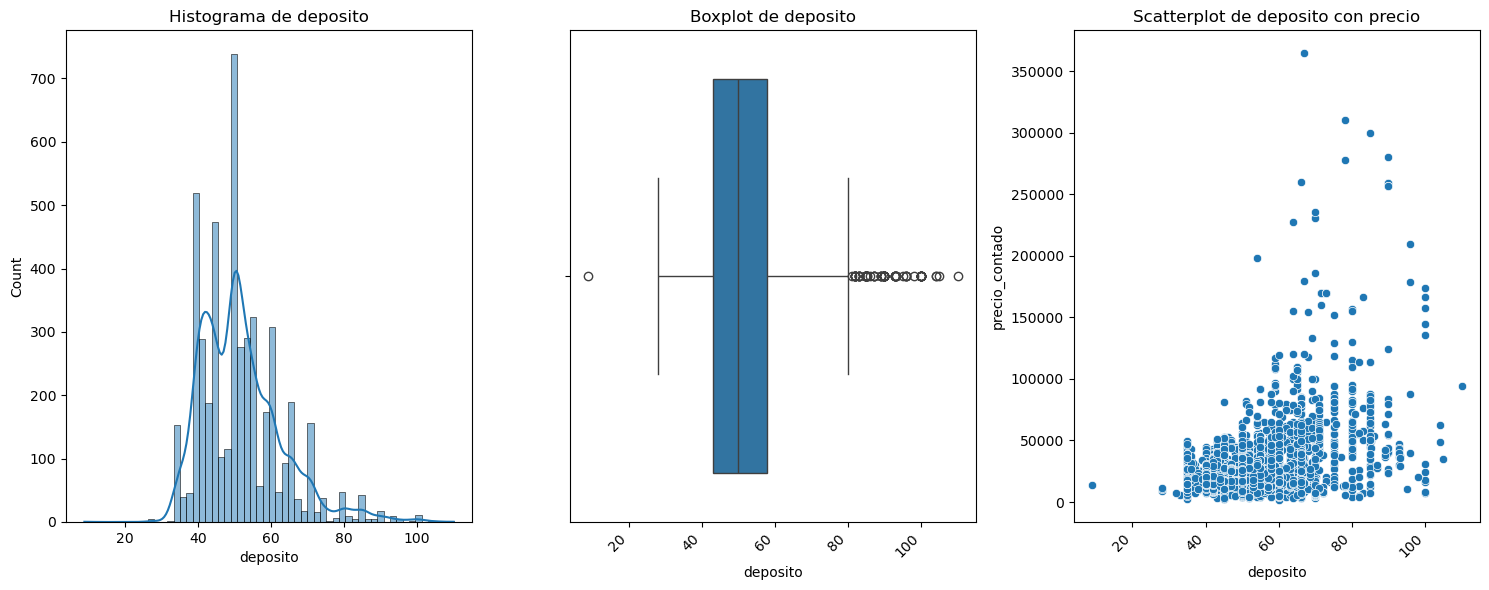

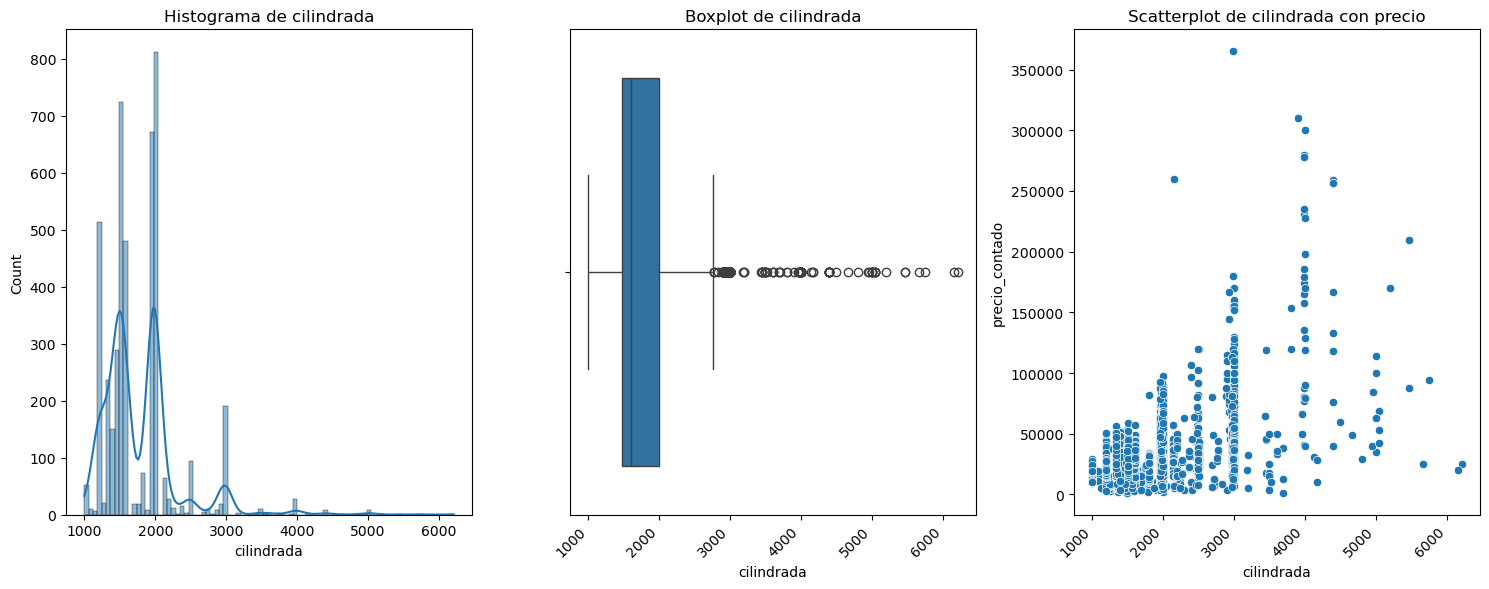

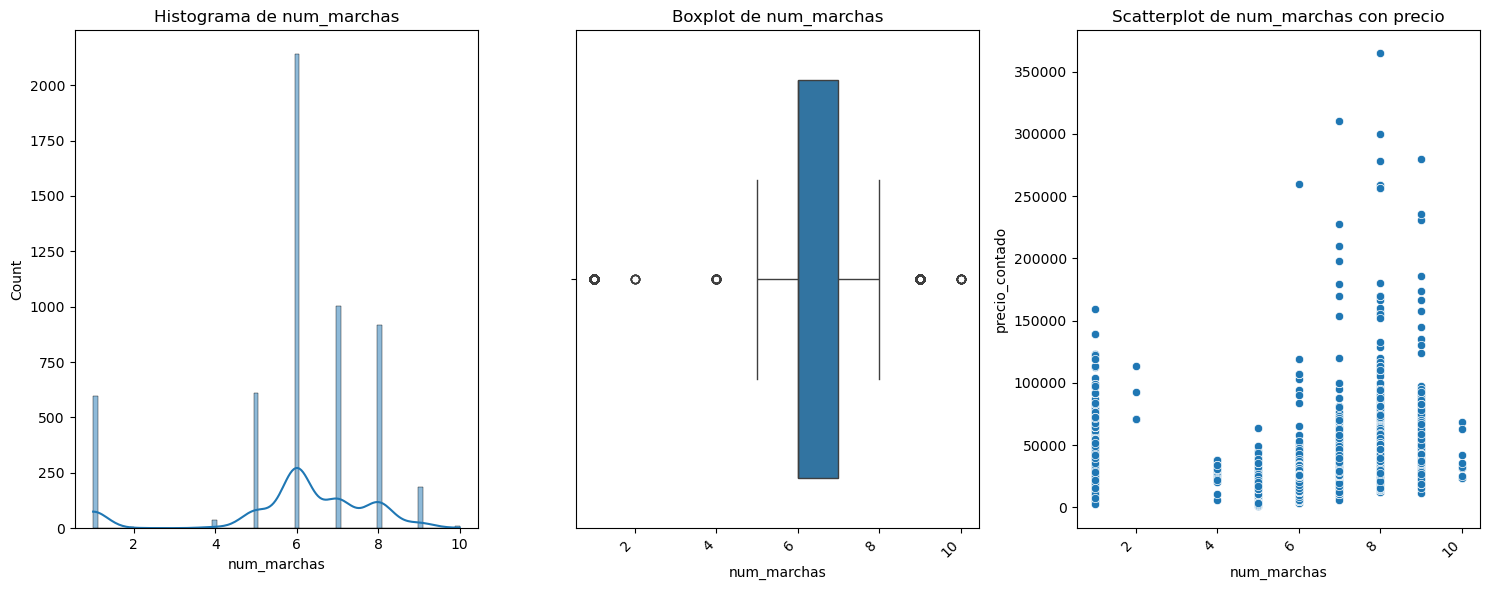

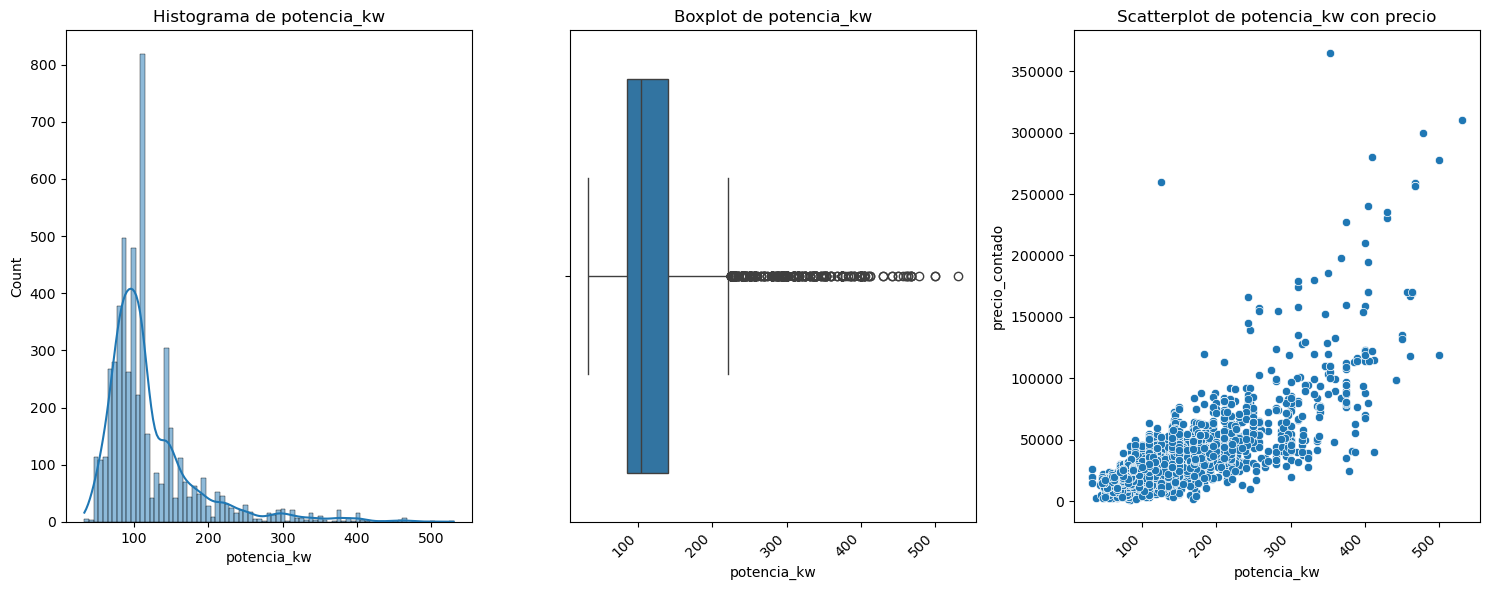

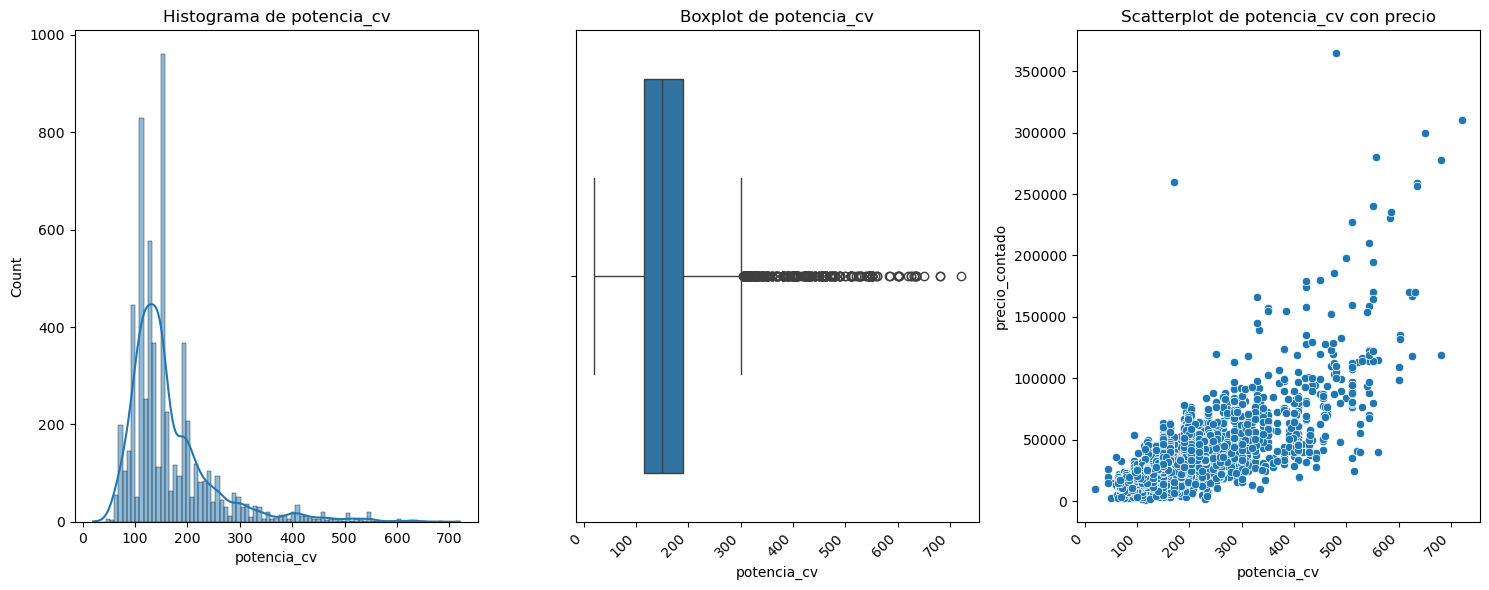

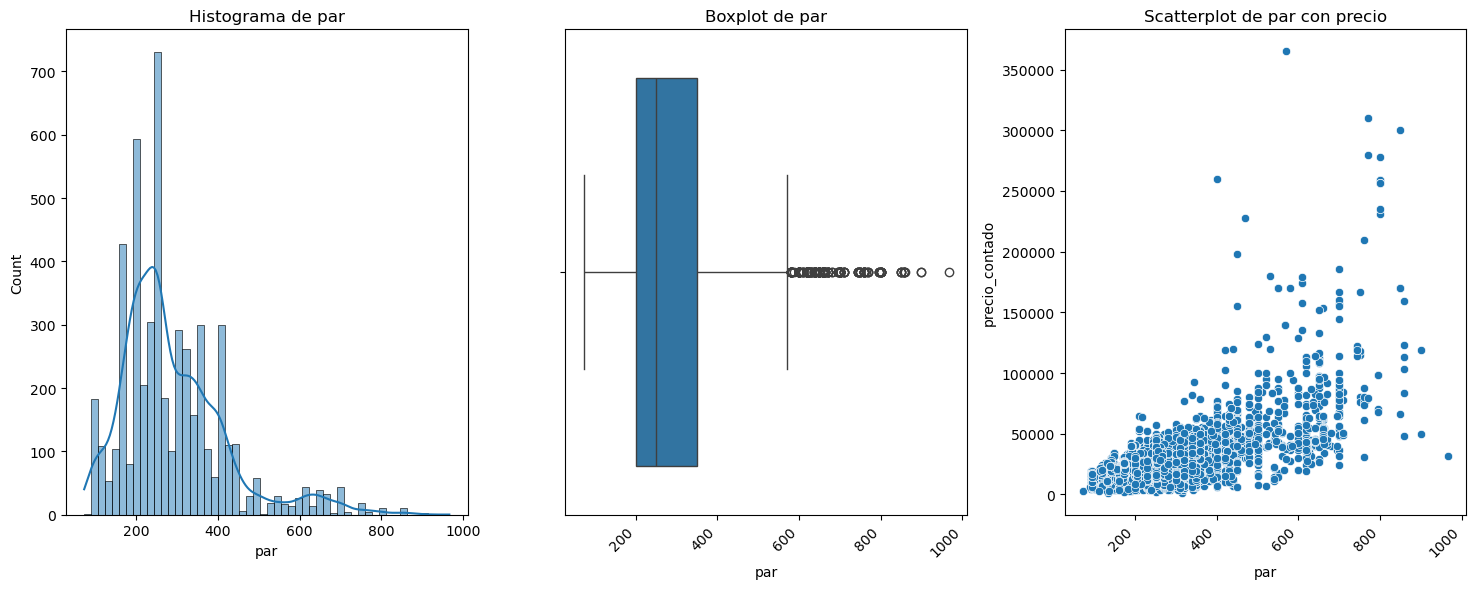

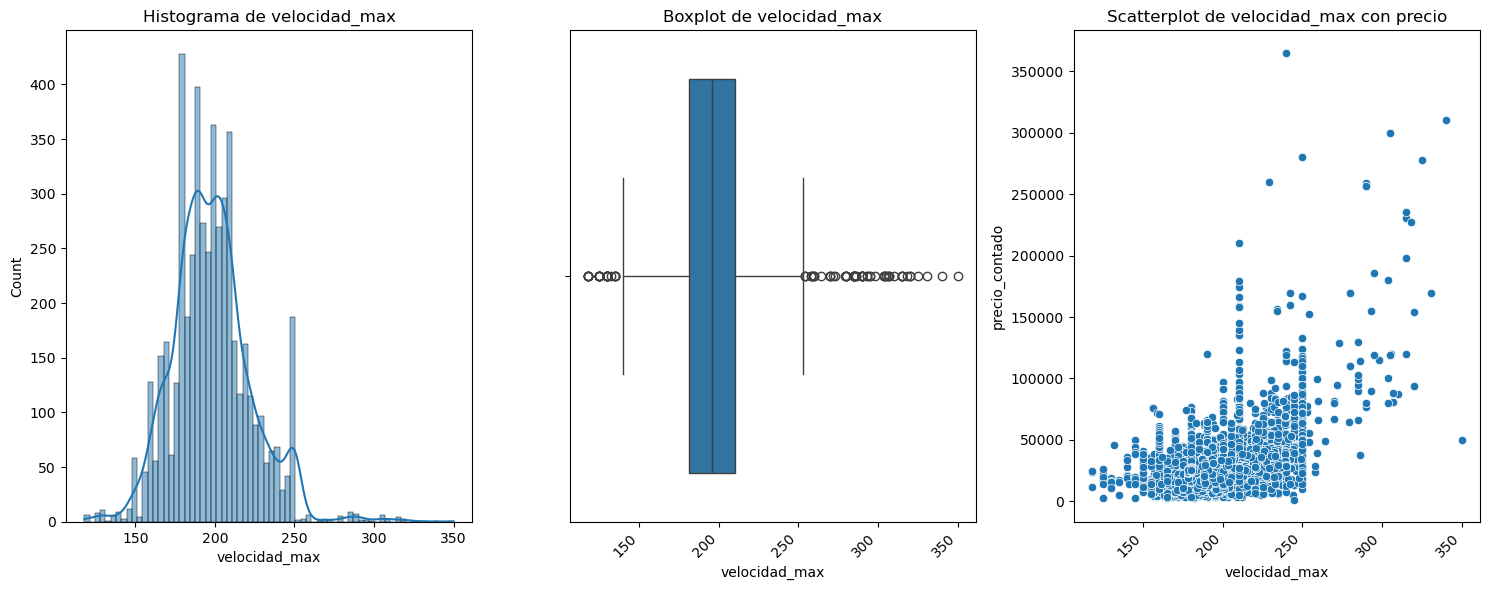

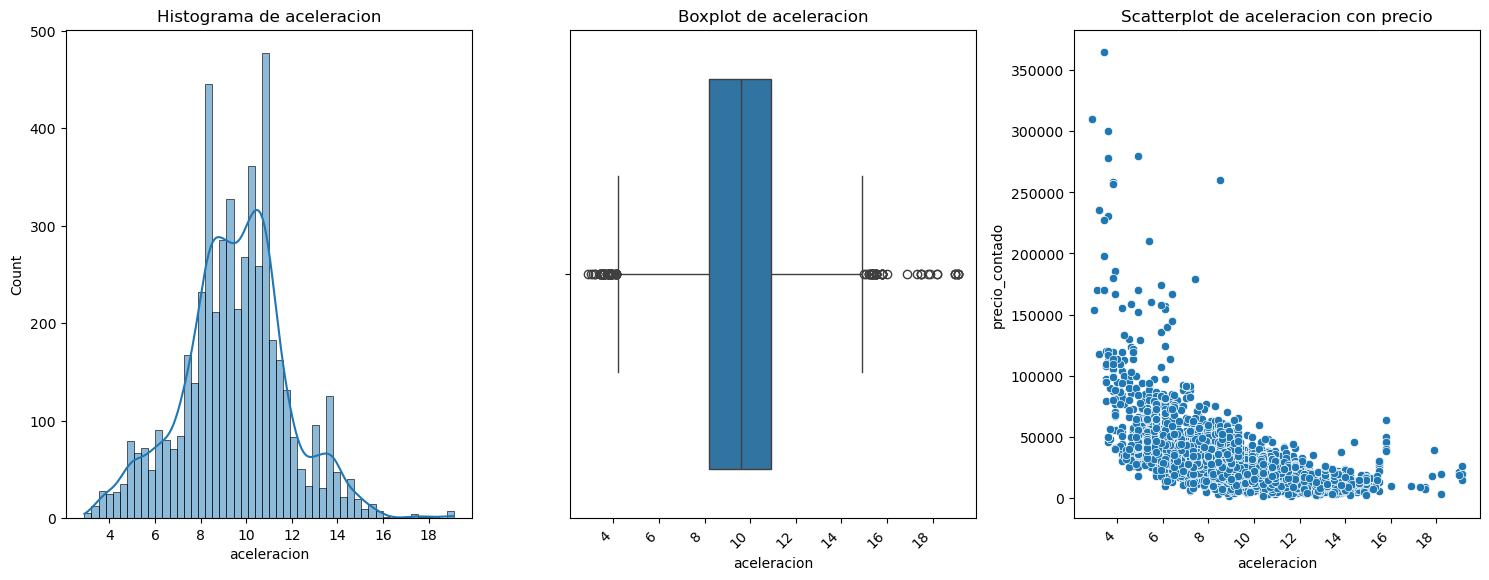

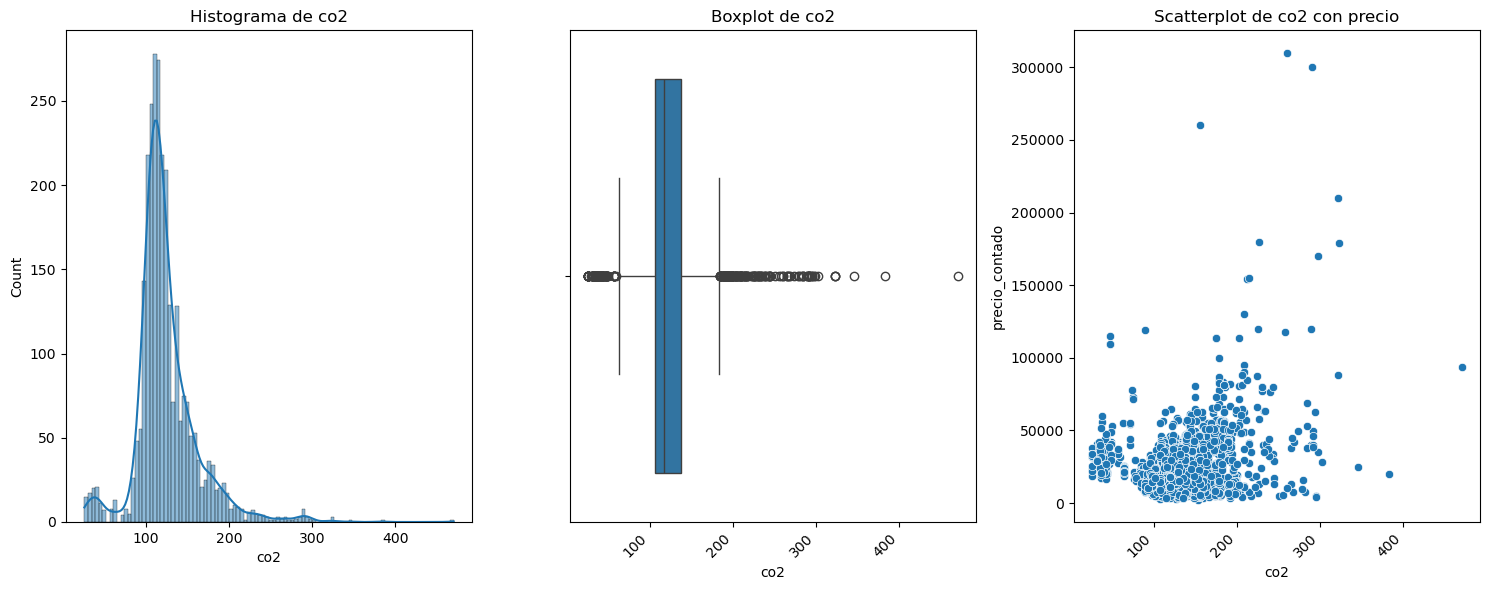

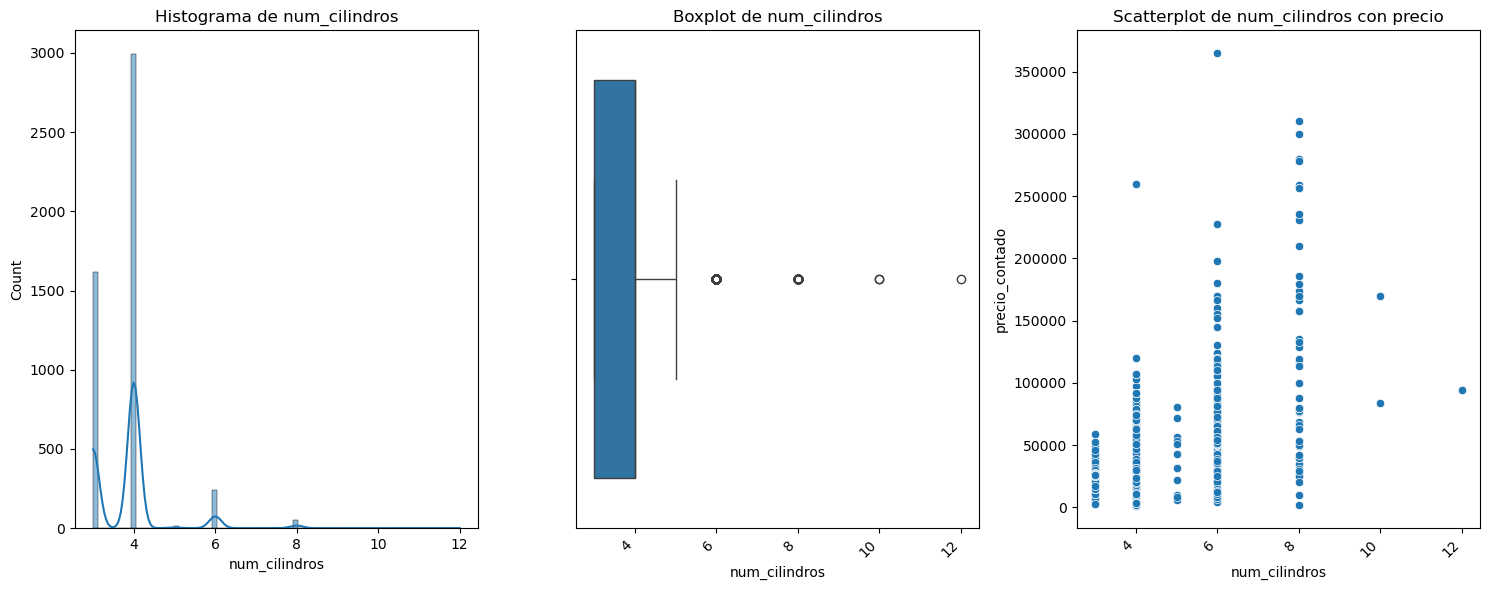

In [33]:
for columna in continuous_columns:
    metricas(df, columna)

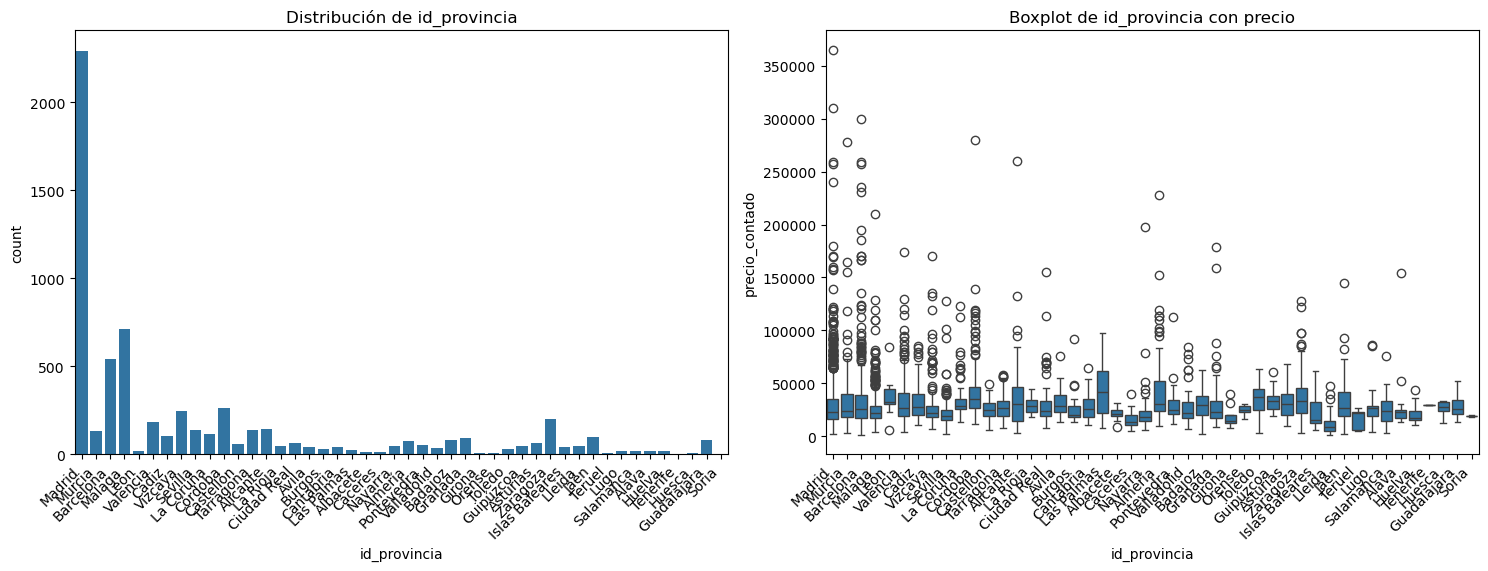

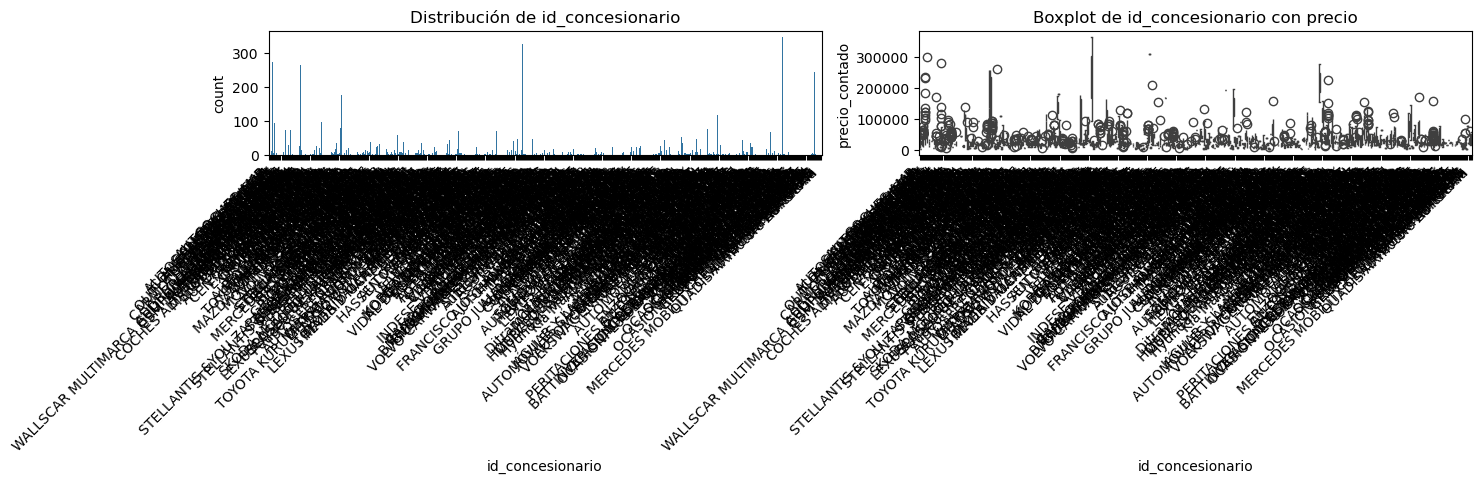

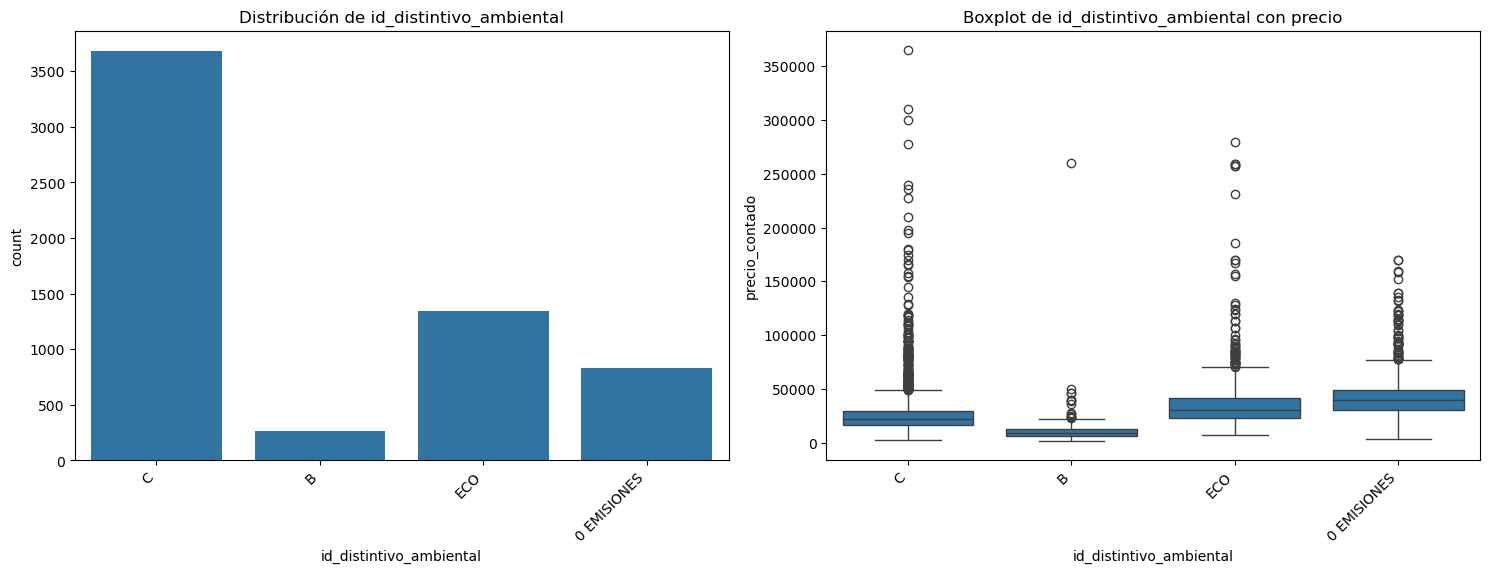

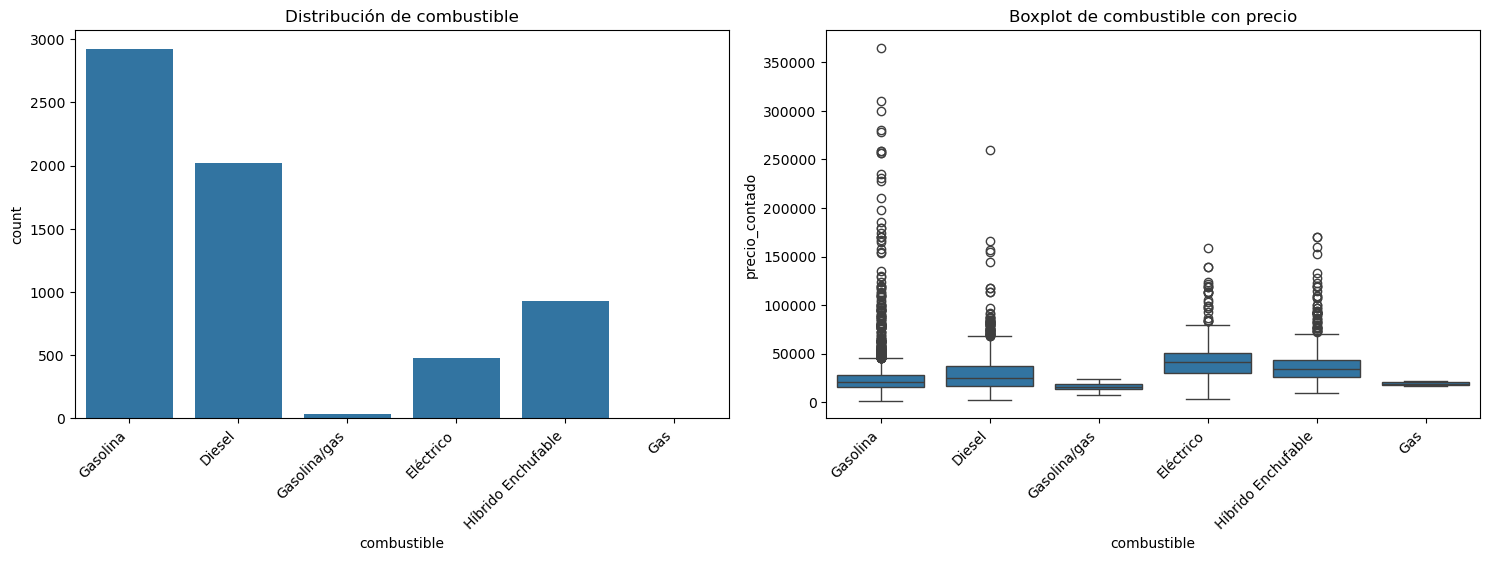

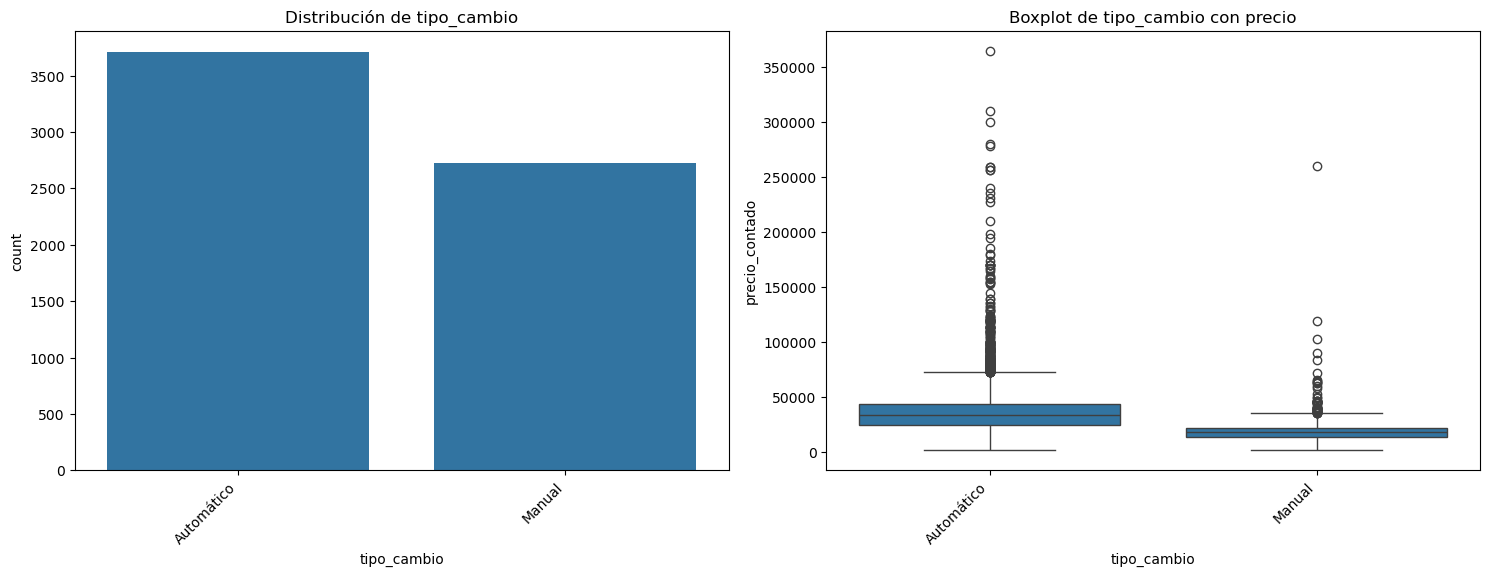

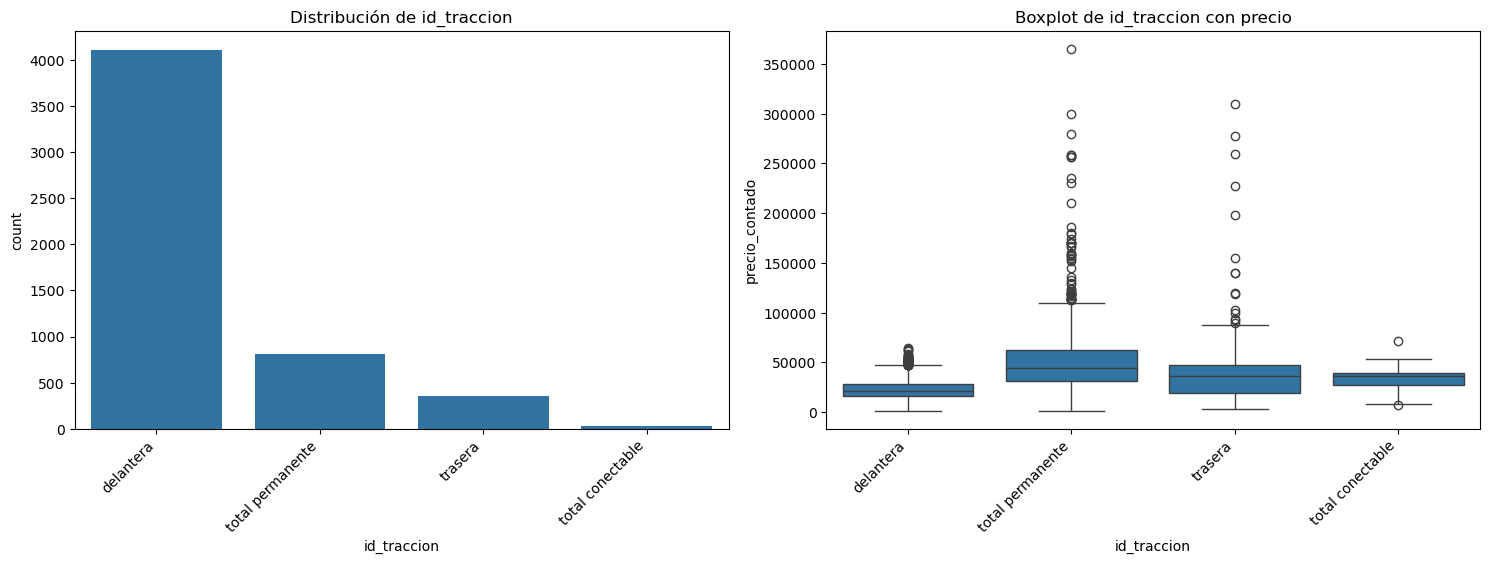

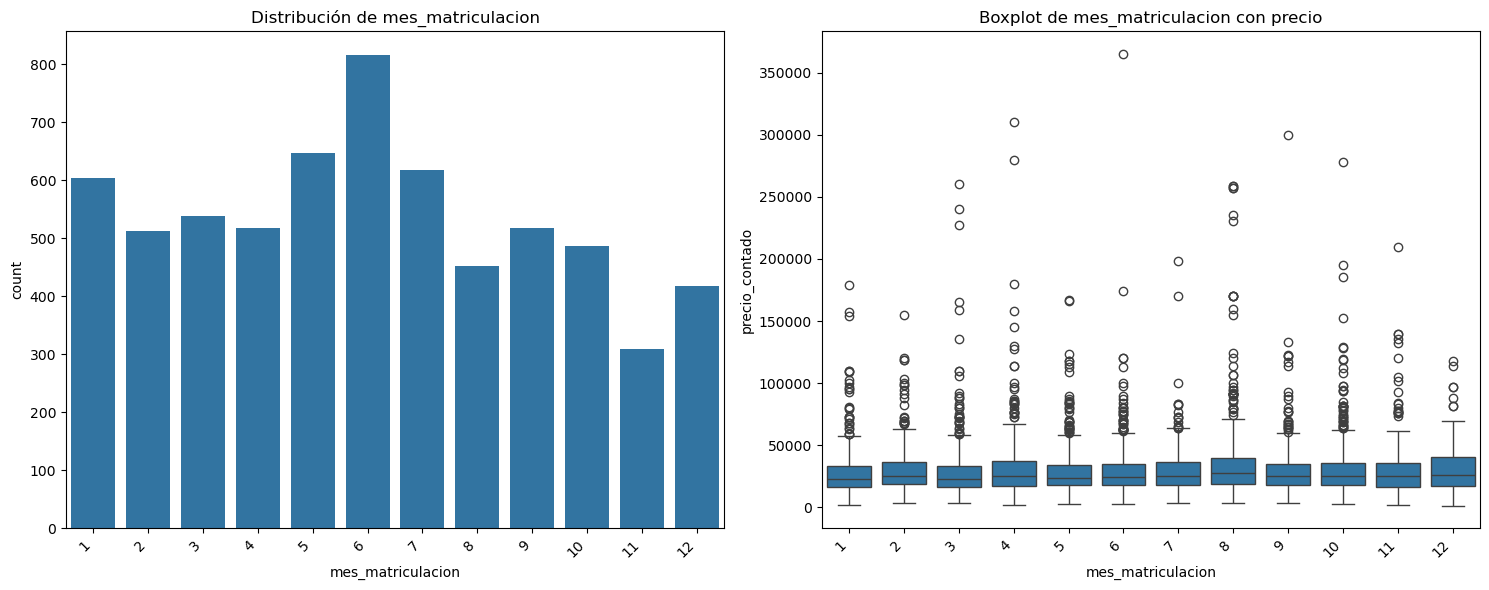

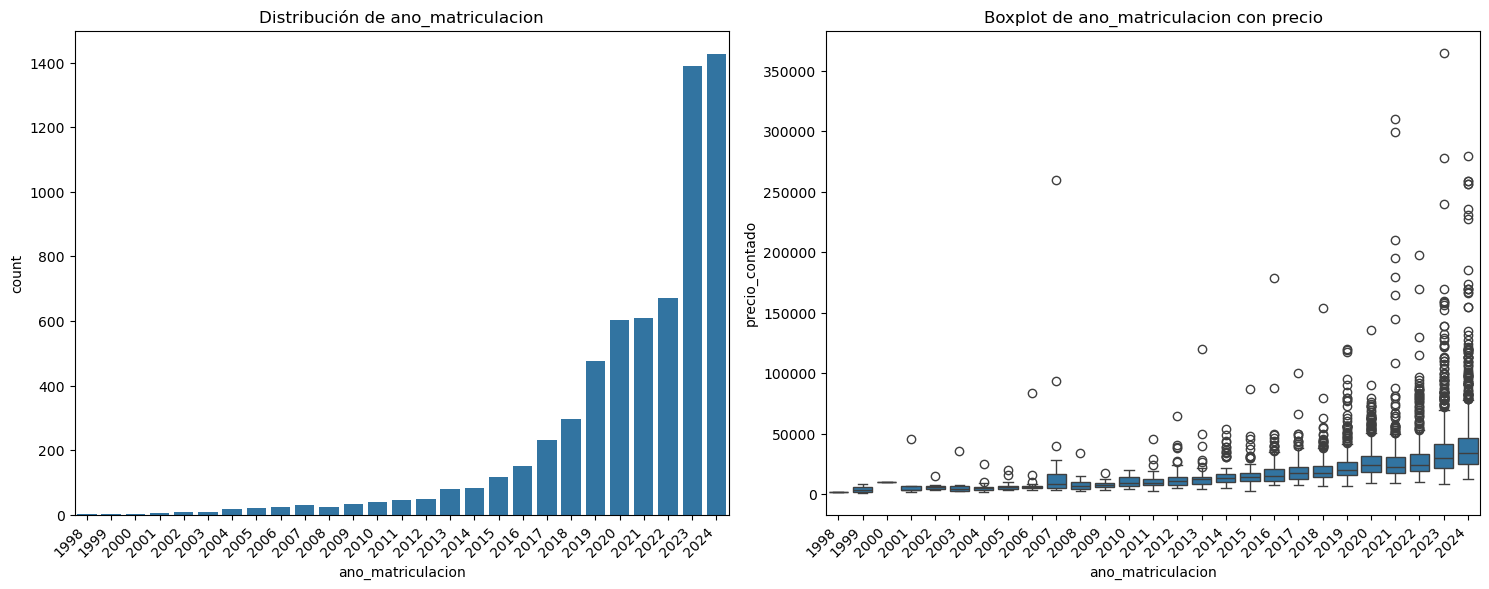

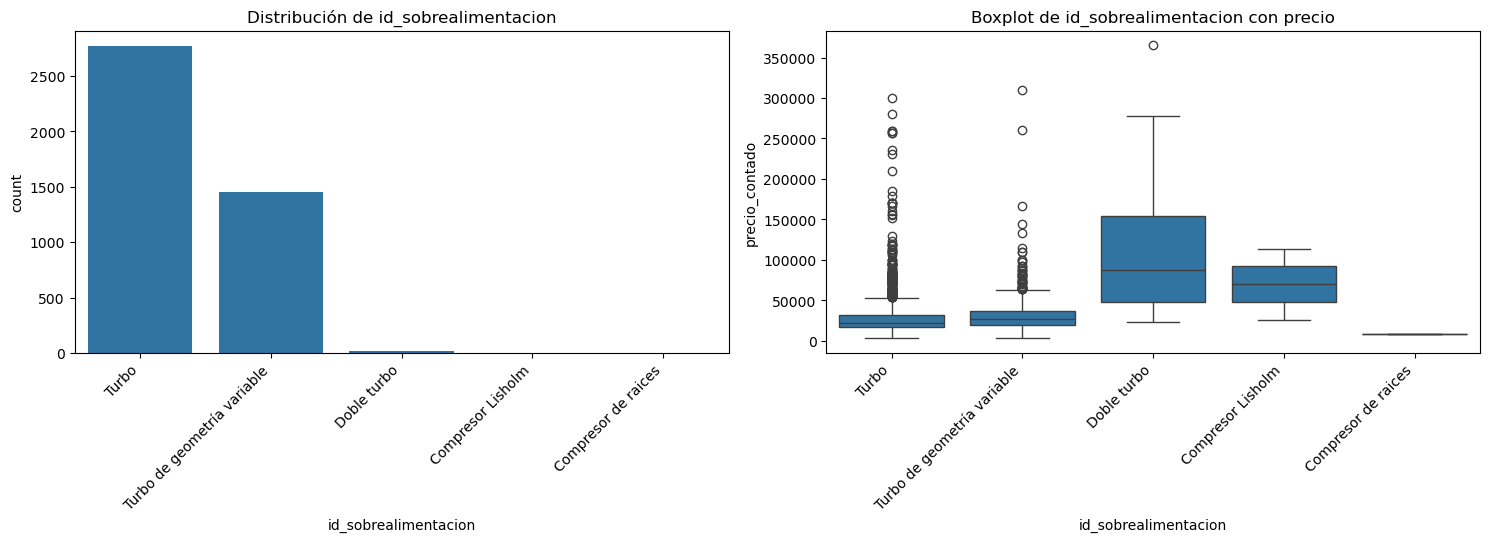

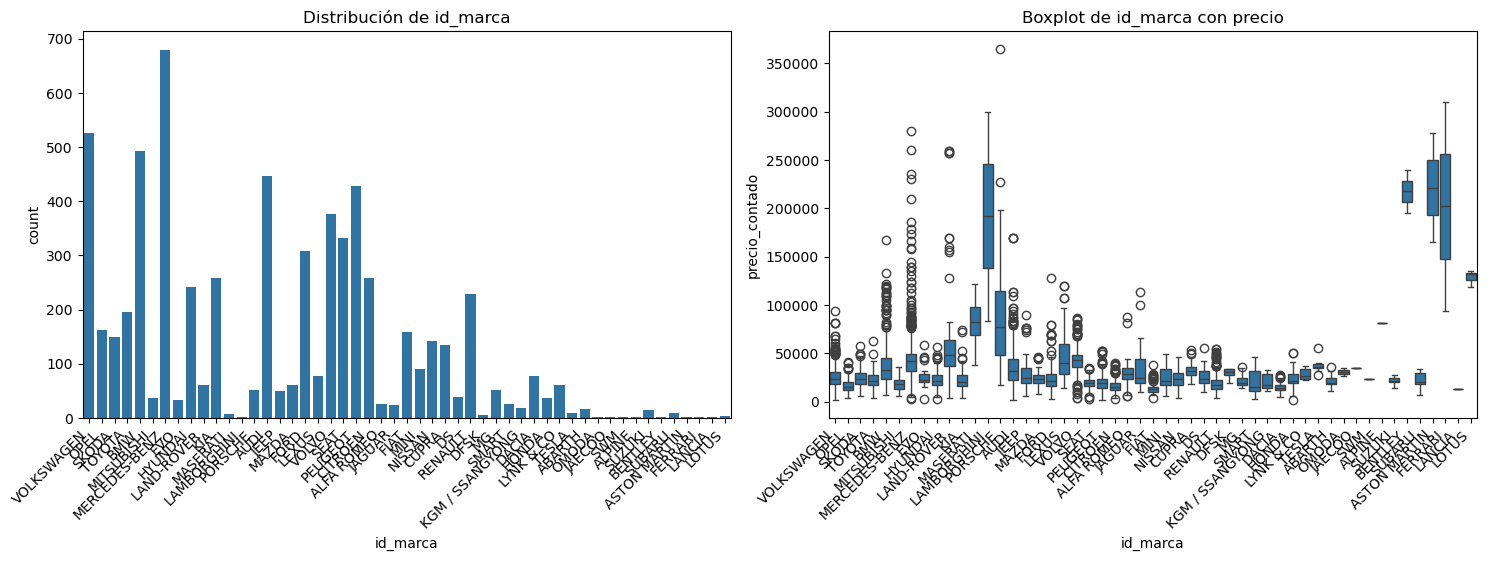

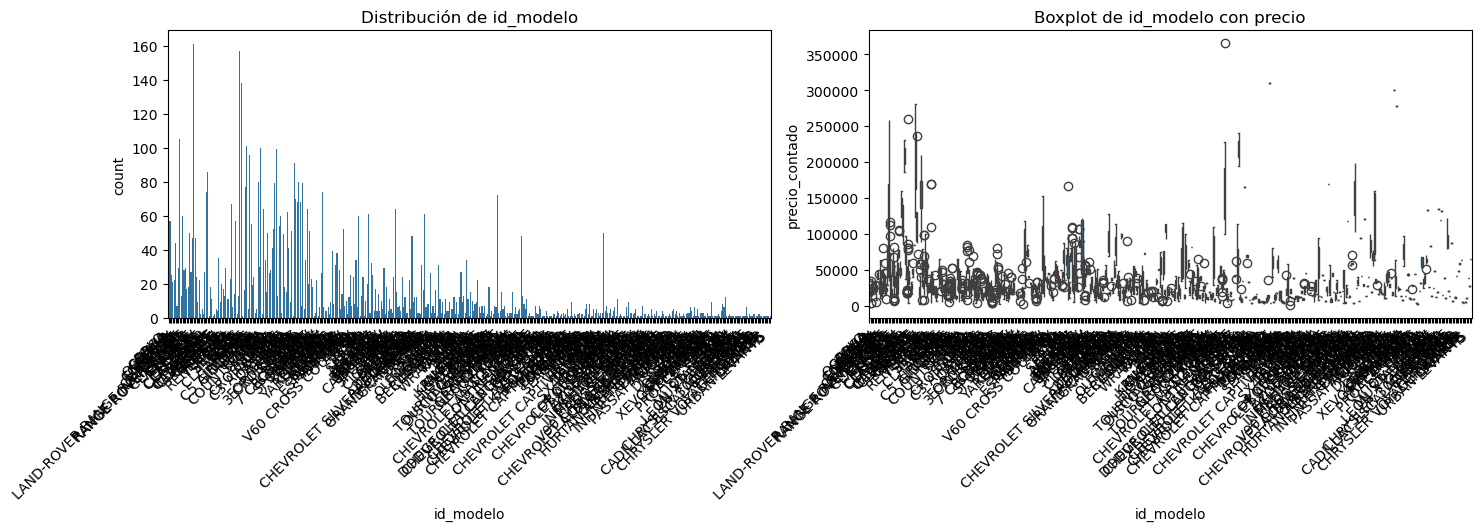

In [34]:
for columna in categorical_columns:
    metricas(df, columna)

In [35]:
correlation_matrix = df[continuous_columns].corr()

plt.figure(figsize=(25, 15))

sns.heatmap(correlation_matrix, annot=True)

plt.title('Mapa de Calor de Correlaciones')
plt.show()

ValueError: could not convert string to float: 'https://www.autocasion.com/coches-segunda-mano/volkswagen-polo-ocasion/polo-2-0-tsi-gti-dsg-ref14587204'